In [1]:
pip install opencv-python imutils scipy numpy matplotlib tensorflow==2.12 mediapipe

  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
facenet-pytorch 2.6.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 1.23.5 which is incompatible.


In [2]:
pip install PyAudio


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fer opencv-python dlib mediapipe numpy matplotlib speechrecognition unidecode



  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.


In [2]:
pip install --user opencv-contrib-python mediapipe fer

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install dlib

In [3]:
# import cv2
# import dlib

# # Teste OpenCV
# print(f"OpenCV version: {cv2.__version__}")

# # Teste Dlib
# detector = dlib.get_frontal_face_detector()
# print("Dlib está funcionando corretamente.")


OpenCV version: 4.9.0
Dlib está funcionando corretamente.


In [4]:
# import requests
# import bz2
# import shutil

# url = "https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2"
# output_file = "shape_predictor_68_face_landmarks.dat.bz2"

# # Baixa o arquivo
# response = requests.get(url)
# with open(output_file, 'wb') as file:
#     file.write(response.content)

# # Descompacta o arquivo
# with bz2.BZ2File(output_file, "rb") as source, open("shape_predictor_68_face_landmarks.dat", "wb") as dest:
#     shutil.copyfileobj(source, dest)

# print("Download e descompactação concluídos.")

ConnectionError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001C4B442F850>: Failed to resolve 'github.com' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
# import requests

# # URL do arquivo no GitHub
# url = "https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5"
# output_file = "fer2013_mini_XCEPTION.102-0.66.hdf5"

# # Faz o download do arquivo
# response = requests.get(url, stream=True)
# with open(output_file, 'wb') as file:
#     # Escreve o conteúdo em partes para não sobrecarregar a memória
#     shutil.copyfileobj(response.raw, file)

# print(f"Download do arquivo {output_file} concluído.")


In [4]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from scipy.spatial import distance as dist
import time
import datetime
import json
import matplotlib.pyplot as plt
from tkinter import Tk, Label, Button
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from collections import deque
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
import h5py

class ComprehensiveTDAHAnalyzer:
    def __init__(self):
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.eye_ar_thresh = 0.3
        self.eye_ar_consec_frames = 3
        self.hyperfocus_duration_thresh = 60  # segundos
        self.movement_thresh = 50  # pixels
        self.counter = 0
        self.total_blinks = 0
        self.last_movement_time = time.time()
        self.hyperfocus_start_time = None
        self.previous_landmarks = None
        self.daily_data = {}
        self.calibration_data = {"blink_rate": [], "movement": []}
        self.alert_window = None

        try:
            # Carregamos o modelo sem compilar
            self.emotion_model = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5', compile=False)

            # Recompilar o modelo com um novo otimizador
            self.emotion_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            print("Modelo carregado com sucesso.")
        except Exception as e:
            print(f"Erro ao carregar o modelo: {e}")
            self.emotion_model = None

        self.emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        
        # Para rastrear expressões faciais ao longo do tempo
        self.emotion_history = deque(maxlen=10)  # Armazena as últimas 100 emoções detectadas
        self.repetitive_patterns = {}

    def eye_aspect_ratio(self, eye):
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        ear = (A + B) / (2.0 * C)
        return ear

    def calculate_movement(self, current_landmarks):
        if self.previous_landmarks is None:
            self.previous_landmarks = current_landmarks
            return 0
        
        movement = np.mean(np.abs(current_landmarks - self.previous_landmarks))
        self.previous_landmarks = current_landmarks
        return movement

    def detect_emotion(self, face_image):
        roi_gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        roi_gray = cv2.resize(roi_gray, (64, 64))
        roi_gray = roi_gray.astype("float") / 255.0
        roi_gray = img_to_array(roi_gray)
        roi_gray = np.expand_dims(roi_gray, axis=0)

        preds = self.emotion_model.predict(roi_gray)[0]
        emotion_idx = preds.argmax()
        emotion = self.emotion_labels[emotion_idx]

        return emotion, preds[emotion_idx]

    def analyze_frame(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray, 0)
        
        if not faces:
            print("No faces detected.")
            return frame, self.total_blinks, False, 0, 0, None, 0
        
        for face in faces:
            shape = self.landmark_predictor(gray, face)
            shape = face_utils.shape_to_np(shape)
        
            leftEye = shape[42:48]
            rightEye = shape[36:42]
            leftEAR = self.eye_aspect_ratio(leftEye)
            rightEAR = self.eye_aspect_ratio(rightEye)
        
            ear = (leftEAR + rightEAR) / 2.0
        
            if ear < self.eye_ar_thresh:
                self.counter += 1
            else:
                if self.counter >= self.eye_ar_consec_frames:
                    self.total_blinks += 1
                self.counter = 0

            movement = self.calculate_movement(shape)
            
            current_time = time.time()
            if movement > self.movement_thresh:
                self.last_movement_time = current_time
                self.hyperfocus_start_time = None
            elif self.hyperfocus_start_time is None:
                self.hyperfocus_start_time = current_time
            
            hyperfocus_duration = 0
            if self.hyperfocus_start_time:
                hyperfocus_duration = current_time - self.hyperfocus_start_time
            
            is_hyperfocused = hyperfocus_duration > self.hyperfocus_duration_thresh
            
            # Análise de expressão facial
            face_image = frame[face.top():face.bottom(), face.left():face.right()]
            if face_image.size == 0:
                print("Empty face image detected.")
                continue  # Skip this iteration
            
            emotion, confidence = self.detect_emotion(face_image)
            self.emotion_history.append(emotion)
            self.update_repetitive_patterns(emotion)
            
            return frame, self.total_blinks, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence
            
            return frame, self.total_blinks, False, 0, 0, None, 0



    def update_repetitive_patterns(self, emotion):
        print(f"Updating patterns with emotion: {emotion}")
        print(f"Current emotion history (before update): {list(self.emotion_history)}")
        print(f"Type of emotion_history: {type(self.emotion_history)}")
        
        pattern_length = 2  # Mantido como 2 para testes

        # Verifique se a emotion_history é uma deque e se o comprimento é suficiente
        if isinstance(self.emotion_history, deque):
            if len(self.emotion_history) < pattern_length:
                print(f"Not enough history for pattern detection: {list(self.emotion_history)}")
                return
            
            # Extraia a lista de emoções como uma lista normal para fatiamento
            emotion_list = list(self.emotion_history)
        
            # Encontre padrões
            for i in range(len(emotion_list) - pattern_length + 1):
                pattern = tuple(emotion_list[i:i + pattern_length])
                if pattern in self.repetitive_patterns:
                    self.repetitive_patterns[pattern] += 1
                else:
                    self.repetitive_patterns[pattern] = 1
        
                # Imprimindo padrões detectados
                print(f"Detected pattern: {pattern}, Count: {self.repetitive_patterns[pattern]}")
        else:
            print(f"Unexpected type for emotion_history: {type(self.emotion_history)}")



    def process_video(self, video_path, task_name=None, max_duration=30):
        cap = cv2.VideoCapture(video_path)
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame, blink_count, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence = self.analyze_frame(frame)
            
            elapsed_time = time.time() - start_time

            # Verifique se o tempo máximo foi alcançado
            if elapsed_time > max_duration:
                print("Tempo máximo de execução alcançado.")
                break
            
            blink_rate = blink_count / (elapsed_time / 60) if elapsed_time > 0 else 0

            cv2.putText(frame, f"Blinks: {blink_count}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f"Blink Rate: {blink_rate:.2f}/min", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            if is_hyperfocused:
                cv2.putText(frame, f"HYPERFOCUSED: {hyperfocus_duration:.1f}s", (10, 90),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                self.show_alert("Hyperfocus Detected", f"You've been hyperfocused for {hyperfocus_duration:.1f} seconds. Consider taking a break.")
            
            if emotion:
                cv2.putText(frame, f"Emotion: {emotion} ({confidence:.2f})", (10, 120),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("q"):  # Pressione 'q' para sair
                break

        cap.release()
        cv2.destroyAllWindows()

        self.update_daily_data(task_name, blink_rate, is_hyperfocused, hyperfocus_duration, movement, emotion)
        return blink_rate, is_hyperfocused

    def update_daily_data(self, task_name, blink_rate, is_hyperfocused, hyperfocus_duration, movement, emotion):
        today = datetime.date.today().isoformat()
        if today not in self.daily_data:
            self.daily_data[today] = {"tasks": {}, "total_hyperfocus_time": 0, "average_blink_rate": 0, "total_movement": 0, "emotions": {}}
        
        if task_name:
            if task_name not in self.daily_data[today]["tasks"]:
                self.daily_data[today]["tasks"][task_name] = []
            self.daily_data[today]["tasks"][task_name].append({
                "blink_rate": blink_rate,
                "hyperfocus_duration": hyperfocus_duration if is_hyperfocused else 0,
                "movement": movement,
                "emotion": emotion
            })
        
        self.daily_data[today]["total_hyperfocus_time"] += hyperfocus_duration if is_hyperfocused else 0
        self.daily_data[today]["average_blink_rate"] = np.mean([task["blink_rate"] for tasks in self.daily_data[today]["tasks"].values() for task in tasks])
        self.daily_data[today]["total_movement"] += movement
        
        if emotion:
            if emotion not in self.daily_data[today]["emotions"]:
                self.daily_data[today]["emotions"][emotion] = 0
            self.daily_data[today]["emotions"][emotion] += 1

    def generate_daily_report(self):
        today = datetime.date.today().isoformat()
        if today not in self.daily_data:
            return "No data available for today."

        report = f"Daily Report for {today}\n\n"
        report += f"Total Hyperfocus Time: {self.daily_data[today]['total_hyperfocus_time']:.2f} seconds\n"
        report += f"Average Blink Rate: {self.daily_data[today]['average_blink_rate']:.2f} blinks/min\n"
        report += f"Total Movement: {self.daily_data[today]['total_movement']:.2f}\n\n"

        report += "Emotion Summary:\n"
        for emotion, count in self.daily_data[today]['emotions'].items():
            report += f"  {emotion}: {count} times\n"
        report += "\n"

        for task, data in self.daily_data[today]["tasks"].items():
            report += f"Task: {task}\n"
            report += f"  Average Blink Rate: {np.mean([d['blink_rate'] for d in data]):.2f} blinks/min\n"
            report += f"  Total Hyperfocus Time: {sum([d['hyperfocus_duration'] for d in data]):.2f} seconds\n"
            report += f"  Average Movement: {np.mean([d['movement'] for d in data]):.2f}\n"
            task_emotions = {}
            for d in data:
                if d['emotion'] not in task_emotions:
                    task_emotions[d['emotion']] = 0
                task_emotions[d['emotion']] += 1
            report += "  Emotions:\n"
            for emotion, count in task_emotions.items():
                report += f"    {emotion}: {count} times\n"
            report += "\n"

        report += "Repetitive Emotion Patterns:\n"
        for pattern, count in sorted(self.repetitive_patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
            report += f"  {' -> '.join(pattern)}: {count} times\n"

        return report

    def save_data(self, filename="tdah_data.json"):
        with open(filename, "w") as f:
            json.dump(self.daily_data, f)

    def load_data(self, filename="tdah_data.json"):
        try:
            with open(filename, "r") as f:
                self.daily_data = json.load(f)
        except FileNotFoundError:
            print("No previous data found.")

    def calibrate(self, duration=60):
        print(f"Starting calibration for {duration} seconds. Please look at the screen normally.")
        cap = cv2.VideoCapture(0)
        start_time = time.time()
        
        while time.time() - start_time < duration:
            ret, frame = cap.read()
            if not ret:
                break

            _, blink_count, _, _, movement, _, _ = self.analyze_frame(frame)
            
            elapsed_time = time.time() - start_time
            blink_rate = blink_count / (elapsed_time / 60) if elapsed_time > 0 else 0

            self.calibration_data["blink_rate"].append(blink_rate)
            self.calibration_data["movement"].append(movement)

            cv2.putText(frame, "Calibrating...", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow("Calibration", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        cap.release()
        cv2.destroyAllWindows()

        self.eye_ar_thresh = np.mean(self.calibration_data["blink_rate"]) * 0.7
        self.movement_thresh = np.mean(self.calibration_data["movement"]) * 1.5

        print(f"Calibration complete. New thresholds - Blink: {self.eye_ar_thresh:.2f}, Movement: {self.movement_thresh:.2f}")

    def show_alert(self, title, message):
        if self.alert_window is None:
            self.alert_window = Tk()
            self.alert_window.title(title)
            Label(self.alert_window, text=message).pack()
            Button(self.alert_window, text="OK", command=self.alert_window.destroy).pack()
            self.alert_window.mainloop()

    def visualize_data(self):
        if not self.daily_data:
            print("No data available to visualize.")
            return
    
        dates = list(self.daily_data.keys())
    
        # Verificamos se os dados estão no formato esperado
        try:
            hyperfocus_times = [
                data["total_hyperfocus_time"] for data in self.daily_data.values()
            ]
            blink_rates = [
                data["average_blink_rate"] for data in self.daily_data.values()
            ]
        except (TypeError, KeyError) as e:
            print(f"Error processing data: {e}")
            return
    
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
        ax1.plot(dates, hyperfocus_times, marker='o')
        ax1.set_title("Daily Hyperfocus Time")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Time (seconds)")
        ax1.tick_params(axis='x', rotation=45)
    
        ax2.plot(dates, blink_rates, marker='o', color='red')
        ax2.set_title("Daily Average Blink Rate")
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Blinks per minute")
        ax2.tick_params(axis='x', rotation=45)
    
        plt.tight_layout()
        plt.show()


# Uso:
analyzer = ComprehensiveTDAHAnalyzer()
analyzer.load_data()  # Carrega dados anteriores, se existirem
analyzer.calibrate()  # Executa a calibração inicial
blink_rate, is_hyperfocused = analyzer.process_video(0, "Reading")  # 30 segundos  # 0 para webcam ao vivo
print(analyzer.generate_daily_report())
analyzer.save_data()
analyzer.visualize_data()


Modelo carregado com sucesso.
Starting calibration for 60 seconds. Please look at the screen normally.
1/1 [==============================] - 1s 655ms/step
Updating patterns with emotion: Happy
Current emotion history (before update): ['Happy']
Type of emotion_history: <class 'collections.deque'>
Not enough history for pattern detection: ['Happy']
1/1 [==============================] - 0s 37ms/step
Updating patterns with emotion: Happy
Current emotion history (before update): ['Happy', 'Happy']
Type of emotion_history: <class 'collections.deque'>
Detected pattern: ('Happy', 'Happy'), Count: 1
1/1 [==============================] - 0s 47ms/step
Updating patterns with emotion: Happy
Current emotion history (before update): ['Happy', 'Happy', 'Happy']
Type of emotion_history: <class 'collections.deque'>
Detected pattern: ('Happy', 'Happy'), Count: 2
Detected pattern: ('Happy', 'Happy'), Count: 3
1/1 [==============================] - 0s 56ms/step
Updating patterns with emotion: Happy
Curr

In [5]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from scipy.spatial import distance as dist
import time
import datetime
import json
import matplotlib.pyplot as plt
from tkinter import Tk, Label, Button
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from collections import deque
import tensorflow as tf
import os

class ADHDAnalyzer:
    def __init__(self):
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.emotion_model = self.load_emotion_model()
        self.reset_analysis_params()
        self.repetitive_patterns = {}
        self.data_file = 'adhd_data.json'  # Nome do arquivo para salvar os dados
        self.daily_data = {}

    def load_emotion_model(self):
        try:
            model = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5', compile=False)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy', metrics=['accuracy'])
            print("Emotion model loaded successfully.")
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

    def reset_analysis_params(self):
        self.eye_ar_thresh = 0.3
        self.eye_ar_consec_frames = 3
        self.movement_thresh = 50  # pixels
        self.counter = 0
        self.total_blinks = 0
        self.previous_landmarks = None
        self.calibration_data = {"blink_rate": [], "movement": []}
        self.emotion_history = deque(maxlen=10)
        self.emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']  # Ajuste se necessário

    def eye_aspect_ratio(self, eye):
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def calculate_movement(self, current_landmarks):
        if self.previous_landmarks is None:
            self.previous_landmarks = current_landmarks
            return 0
        movement = np.mean(np.abs(current_landmarks - self.previous_landmarks))
        self.previous_landmarks = current_landmarks
        return movement

    def detect_emotion(self, face_image):
        roi_gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        roi_gray = cv2.resize(roi_gray, (64, 64))
        roi_gray = roi_gray.astype("float") / 255.0
        roi_gray = img_to_array(roi_gray)
        roi_gray = np.expand_dims(roi_gray, axis=0)

        preds = self.emotion_model.predict(roi_gray)[0]
        emotion_idx = preds.argmax()
        emotion = self.emotion_labels[emotion_idx]
        return emotion, preds[emotion_idx]

    def analyze_frame(self, frame):
        # Detecta rostos
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray, 0)

        blink_count = 0
        is_hyperfocused = False
        hyperfocus_duration = 0
        movement = 0
        emotion = None
        confidence = 0

        for face in faces:
            shape = self.landmark_predictor(gray, face)
            shape = face_utils.shape_to_np(shape)
            left_eye = shape[42:48]
            right_eye = shape[36:42]

            # Calcula a taxa de aspecto dos olhos (EAR)
            left_eye_ar = self.eye_aspect_ratio(left_eye)
            right_eye_ar = self.eye_aspect_ratio(right_eye)
            ear = (left_eye_ar + right_eye_ar) / 2.0
            
            # Detecta piscadas
            if ear < self.eye_ar_thresh:
                self.counter += 1
            else:
                if self.counter >= self.eye_ar_consec_frames:
                    blink_count += 1
                self.counter = 0
            
            # Detecta movimento
            movement = self.calculate_movement(shape)
            
            # Detecta emoção
            try:
                emotion_face = frame[face.top():face.bottom(), face.left():face.right()]
                emotion, confidence = self.detect_emotion(emotion_face)
            except Exception as e:
                print(f"Error detecting emotion: {e}")
                emotion = None
                confidence = 0

            # Verifica se a pessoa está em hiperfoco
            if movement < self.movement_thresh:
                hyperfocus_duration += 1  # Incrementa se o movimento for baixo
                if hyperfocus_duration > 60:  # Se durar mais de 60 frames
                    is_hyperfocused = True
            else:
                hyperfocus_duration = 0  # Reinicia se houver movimento

        self.total_blinks += blink_count
        return frame, self.total_blinks, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence

    def process_video(self, video_path, task_name=None, max_duration=300):
        cap = cv2.VideoCapture(video_path)
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame, blink_count, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence = self.analyze_frame(frame)
            
            elapsed_time = time.time() - start_time

            # Verifique se o tempo máximo foi alcançado
            if elapsed_time > max_duration:
                print("Tempo máximo de execução alcançado.")
                break
            
            blink_rate = blink_count / (elapsed_time / 60) if elapsed_time > 0 else 0

            cv2.putText(frame, f"Blinks: {blink_count}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f"Blink Rate: {blink_rate:.2f}/min", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            if is_hyperfocused:
                cv2.putText(frame, f"HYPERFOCUSED: {hyperfocus_duration:.1f}s", (10, 90),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                self.show_alert("Hyperfocus Detected", f"You've been hyperfocused for {hyperfocus_duration:.1f} seconds. Consider taking a break.")
            
            if emotion:
                cv2.putText(frame, f"Emotion: {emotion} ({confidence:.2f})", (10, 120),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("q"):  # Pressione 'q' para sair
                break

        cap.release()
        cv2.destroyAllWindows()

        self.update_daily_data(task_name, blink_rate, is_hyperfocused, hyperfocus_duration, movement, emotion)
        return blink_rate, is_hyperfocused

    def update_daily_data(self, task_name, blink_rate, is_hyperfocused, hyperfocus_duration, movement, emotion):
        # Atualiza os dados diários
        if task_name not in self.daily_data:
            self.daily_data[task_name] = []
        self.daily_data[task_name].append({
            "timestamp": str(datetime.datetime.now()),
            "blink_rate": blink_rate,
            "is_hyperfocused": is_hyperfocused,
            "hyperfocus_duration": hyperfocus_duration,
            "movement": movement,
            "emotion": emotion
        })

    def generate_daily_report(self):
        # Gera um relatório diário
        report = {}
        for task, entries in self.daily_data.items():
            report[task] = {
                "total_blinks": sum(entry["blink_rate"] for entry in entries),
                "hyperfocus_count": sum(entry["is_hyperfocused"] for entry in entries),
                "average_movement": np.mean([entry["movement"] for entry in entries]),
                "emotions": [entry["emotion"] for entry in entries if entry["emotion"]]
            }
        return report

    def visualize_data(self):
        # Visualiza os dados diários
        for task, entries in self.daily_data.items():
            blink_rates = [entry["blink_rate"] for entry in entries]
            plt.plot(blink_rates, label=task)
        plt.title("Blink Rates by Task")
        plt.xlabel("Time")
        plt.ylabel("Blink Rate")
        plt.legend()
        plt.show()

    def show_alert(self, title, message):
        # Exibe um alerta simples (exemplo com tkinter)
        alert = Tk()
        alert.title(title)
        Label(alert, text=message).pack()
        Button(alert, text="OK", command=alert.destroy).pack()
        alert.mainloop()

# Uso
analyzer = ADHDAnalyzer()
# Aqui você deve carregar dados salvos se necessário, por exemplo:
# analyzer.load_data()
blink_rate, is_hyperfocused = analyzer.process_video(0, "Reading", max_duration=30)  # 300 segundos = 5 minutos
print(analyzer.generate_daily_report())
# Salve dados analisados, se necessário:
# analyzer.save_data()


Emotion model loaded successfully.
1/1 [==============================] - 0s 26ms/step
{'Reading': {'total_blinks': 37.18963525837342, 'hyperfocus_count': 0, 'average_movement': 0.7794117647058824, 'emotions': ['Neutral']}}


In [6]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from scipy.spatial import distance as dist
import time
import datetime
import json
import matplotlib.pyplot as plt
from tkinter import Tk, Label, Button
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from collections import deque
import tensorflow as tf
import os

class NeuroBehaviorAnalyzer:
    def __init__(self):
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.emotion_model = self.load_emotion_model_transfer()
        self.reset_analysis_params()
        self.data_file = 'behavior_data.json'  # Nome do arquivo para salvar dados
        self.daily_data = {}
        self.movement_history = deque(maxlen=30)  # Histórico de movimento para estereotipias

    def load_emotion_model_transfer(self):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        predictions = Dense(7, activation='softmax')(x)  # 7 classes emocionais
        model = Model(inputs=base_model.input, outputs=predictions)
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        print("Transfer learning emotion model loaded successfully.")
        return model

    def reset_analysis_params(self):
        self.eye_ar_thresh = 0.3
        self.eye_ar_consec_frames = 3
        self.movement_thresh = 50  # Pixels
        self.counter = 0
        self.total_blinks = 0
        self.previous_landmarks = None
        self.emotion_history = deque(maxlen=10)
        self.emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    def eye_aspect_ratio(self, eye):
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def calculate_movement(self, current_landmarks):
        if self.previous_landmarks is None:
            self.previous_landmarks = current_landmarks
            return 0
        movement = np.mean(np.abs(current_landmarks - self.previous_landmarks))
        self.previous_landmarks = current_landmarks
        return movement

    def detect_gaze_direction(self, landmarks):
        left_eye_center = np.mean(landmarks[36:42], axis=0)
        right_eye_center = np.mean(landmarks[42:48], axis=0)
        nose_tip = landmarks[33]  # Ponta do nariz

        dx = (left_eye_center[0] + right_eye_center[0]) / 2 - nose_tip[0]
        dy = (left_eye_center[1] + right_eye_center[1]) / 2 - nose_tip[1]

        if abs(dx) > abs(dy):
            return "Right" if dx > 0 else "Left"
        else:
            return "Up" if dy < 0 else "Down"

    def detect_repetitive_movements(self, threshold=5):
        if len(self.movement_history) < 10:
            return False
        deltas = np.diff(self.movement_history[-10:])
        if np.all(deltas < threshold):
            return True  # Movimento repetitivo detectado
        return False

    def detect_emotion(self, face_image):
        roi_gray = cv2.resize(face_image, (64, 64))
        roi_gray = roi_gray.astype("float") / 255.0
        roi_gray = img_to_array(roi_gray)
        roi_gray = np.expand_dims(roi_gray, axis=0)

        preds = self.emotion_model.predict(roi_gray)[0]
        emotion_idx = preds.argmax()
        emotion = self.emotion_labels[emotion_idx]
        return emotion, preds[emotion_idx]

    def analyze_frame(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray, 0)

        blink_count = 0
        is_hyperfocused = False
        hyperfocus_duration = 0
        movement = 0
        emotion = None
        confidence = 0
        gaze_direction = None

        for face in faces:
            shape = self.landmark_predictor(gray, face)
            shape = face_utils.shape_to_np(shape)
            left_eye = shape[42:48]
            right_eye = shape[36:42]

            # EAR (Taxa de Aspecto dos Olhos)
            left_eye_ar = self.eye_aspect_ratio(left_eye)
            right_eye_ar = self.eye_aspect_ratio(right_eye)
            ear = (left_eye_ar + right_eye_ar) / 2.0

            if ear < self.eye_ar_thresh:
                self.counter += 1
            else:
                if self.counter >= self.eye_ar_consec_frames:
                    blink_count += 1
                self.counter = 0

            # Movimento e histórico de estereotipias
            movement = self.calculate_movement(shape)
            self.movement_history.append(movement)

            # Direção do olhar e estereotipias
            gaze_direction = self.detect_gaze_direction(shape)
            is_stereotypy = self.detect_repetitive_movements()

            # Emoção detectada
            try:
                emotion_face = frame[face.top():face.bottom(), face.left():face.right()]
                emotion, confidence = self.detect_emotion(emotion_face)
            except Exception as e:
                print(f"Error detecting emotion: {e}")

            if movement < self.movement_thresh:
                hyperfocus_duration += 1
                if hyperfocus_duration > 60:
                    is_hyperfocused = True
            else:
                hyperfocus_duration = 0

        self.total_blinks += blink_count
        return frame, blink_count, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence, gaze_direction, is_stereotypy

    def process_video(self, video_path, task_name=None, max_duration=300):
        cap = cv2.VideoCapture(video_path)
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame, blink_count, is_hyperfocused, hyperfocus_duration, movement, emotion, confidence, gaze_direction, is_stereotypy = self.analyze_frame(frame)

            elapsed_time = time.time() - start_time
            if elapsed_time > max_duration:
                print("Tempo máximo de execução alcançado.")
                break

            blink_rate = blink_count / (elapsed_time / 60) if elapsed_time > 0 else 0

            cv2.putText(frame, f"Blinks: {blink_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if is_hyperfocused:
                cv2.putText(frame, "HYPERFOCUSED", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            if emotion:
                cv2.putText(frame, f"Emotion: {emotion} ({confidence:.2f})", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            if is_stereotypy:
                cv2.putText(frame, "Repetitive Movement Detected", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

            cv2.imshow("Frame", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        cap.release()
        cv2.destroyAllWindows()

    def generate_daily_report(self):
        # Gera relatório com todas as métricas
        report = {
            task: {
                "total_blinks": sum(entry["blink_rate"] for entry in entries),
                "hyperfocus_count": sum(entry["is_hyperfocused"] for entry in entries),
                "average_movement": np.mean([entry["movement"] for entry in entries]),
                "stereotypy_count": sum(1 for entry in entries if entry.get("is_stereotypy", False)),
                "gaze_directions": [entry.get("gaze_direction", "Unknown") for entry in entries]
            }
            for task, entries in self.daily_data.items()
        }
        return report

# Uso
analyzer = NeuroBehaviorAnalyzer()
analyzer.process_video(0, "Reading", max_duration=30)  # Webcam ou vídeo
print(analyzer.generate_daily_report())


Transfer learning emotion model loaded successfully.
1/1 [==============================] - 0s 20ms/step


TypeError: sequence index must be integer, not 'slice'

In [3]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from scipy.spatial import distance as dist
import time
import datetime
import json
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
import os
from pathlib import Path
import logging

class NeuroBehaviorAnalyzer:
    def __init__(self, model_path=None, landmark_predictor_path=None):
        """
        Initialize the NeuroBehaviorAnalyzer with configurable paths and logging
        """
        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

        try:
            # Initialize face detection components
            self.face_detector = dlib.get_frontal_face_detector()
            self.landmark_predictor = self.load_landmark_predictor(landmark_predictor_path)
            self.emotion_model = self.load_emotion_model(model_path)
            
            # Initialize analysis parameters
            self.reset_analysis_params()
            
            # Setup data storage
            self.data_directory = Path('behavior_data')
            self.data_directory.mkdir(exist_ok=True)
            
        except Exception as e:
            self.logger.error(f"Initialization error: {str(e)}")
            raise

    def load_landmark_predictor(self, path=None):
        """Load the facial landmark predictor with error handling"""
        try:
            default_path = "shape_predictor_68_face_landmarks.dat"
            predictor_path = path if path else default_path
            
            if not os.path.exists(predictor_path):
                raise FileNotFoundError(f"Landmark predictor file not found at {predictor_path}")
                
            return dlib.shape_predictor(predictor_path)
        except Exception as e:
            self.logger.error(f"Error loading landmark predictor: {str(e)}")
            raise

    def load_emotion_model(self, path=None):
        """Load or create the emotion detection model with error handling"""
        try:
            if path and os.path.exists(path):
                return tf.keras.models.load_model(path)
            
            # Create new model if no path provided or file doesn't exist
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(64, 64, 3)
            )
            
            # Freeze the base model layers
            base_model.trainable = False
            
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            x = Dense(128, activation='relu')(x)
            predictions = Dense(7, activation='softmax')(x)
            
            model = Model(inputs=base_model.input, outputs=predictions)
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            self.logger.info("New emotion model created successfully")
            return model
            
        except Exception as e:
            self.logger.error(f"Error loading emotion model: {str(e)}")
            raise

    def reset_analysis_params(self):
        """Initialize or reset analysis parameters"""
        self.params = {
            'eye_ar_thresh': 0.3,
            'eye_ar_consec_frames': 3,
            'movement_thresh': 50,
            'counter': 0,
            'total_blinks': 0
        }
        
        self.previous_landmarks = None
        self.emotion_history = deque(maxlen=10)
        self.movement_history = deque(maxlen=30)
        self.emotion_labels = [
            'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
        ]

    def analyze_frame(self, frame):
        """
        Analyze a single frame with comprehensive error handling
        """
        try:
            if frame is None:
                raise ValueError("Empty frame received")

            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.face_detector(gray, 0)

            # Initialize result dictionary
            result = {
                'blink_count': 0,
                'is_hyperfocused': False,
                'hyperfocus_duration': 0,
                'movement': 0,
                'emotion': None,
                'confidence': 0,
                'gaze_direction': None,
                'is_stereotypy': False
            }

            if not faces:
                self.logger.warning("No faces detected in frame")
                return frame, result

            # Analyze first detected face
            face = faces[0]
            shape = self.landmark_predictor(gray, face)
            shape = face_utils.shape_to_np(shape)

            # Update results with analysis
            result.update(self.analyze_face_features(frame, face, shape))

            # Draw results on frame
            frame = self.draw_analysis_results(frame, result)

            return frame, result

        except Exception as e:
            self.logger.error(f"Frame analysis error: {str(e)}")
            return frame, None

    def analyze_face_features(self, frame, face, shape):
        """Analyze facial features and return results"""
        results = {}
        
        # Analyze blinks
        left_eye = shape[42:48]
        right_eye = shape[36:42]
        ear = self.calculate_eye_aspect_ratio(left_eye, right_eye)
        
        results['blink_count'] = self.update_blink_count(ear)
        
        # Analyze movement
        movement = self.calculate_movement(shape)
        self.movement_history.append(movement)
        results['movement'] = movement
        results['is_stereotypy'] = self.detect_repetitive_movements()
        
        # Analyze gaze
        results['gaze_direction'] = self.detect_gaze_direction(shape)
        
        # Analyze emotion
        try:
            face_roi = frame[face.top():face.bottom(), face.left():face.right()]
            emotion, confidence = self.detect_emotion(face_roi)
            results['emotion'] = emotion
            results['confidence'] = confidence
        except Exception as e:
            self.logger.warning(f"Emotion detection failed: {str(e)}")
            results['emotion'] = None
            results['confidence'] = 0
            
        return results

    def calculate_eye_aspect_ratio(self, left_eye, right_eye):
        """Calculate the eye aspect ratio"""
        left_ear = self.eye_aspect_ratio(left_eye)
        right_ear = self.eye_aspect_ratio(right_eye)
        return (left_ear + right_ear) / 2.0

    def eye_aspect_ratio(self, eye):
        """Calculate the aspect ratio of a single eye"""
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def process_video(self, source, task_name=None, max_duration=300):
        """
        Process video from file or webcam with proper resource management
        """
        try:
            cap = cv2.VideoCapture(source)
            if not cap.isOpened():
                raise ValueError(f"Could not open video source: {source}")

            start_time = time.time()
            frames_processed = 0
            analysis_data = []

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Process frame
                processed_frame, results = self.analyze_frame(frame)
                if results:
                    analysis_data.append(results)
                    self.display_results(processed_frame, results)

                frames_processed += 1
                
                # Check duration
                elapsed_time = time.time() - start_time
                if elapsed_time > max_duration:
                    self.logger.info("Maximum duration reached")
                    break

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        except Exception as e:
            self.logger.error(f"Video processing error: {str(e)}")
        finally:
            cap.release()
            cv2.destroyAllWindows()
            
        # Save analysis data
        if task_name:
            self.save_analysis_data(task_name, analysis_data)
            
        return analysis_data

    def save_analysis_data(self, task_name, data):
        """Save analysis data to JSON file"""
        try:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = self.data_directory / f"{task_name}_{timestamp}.json"
            
            with open(filename, 'w') as f:
                json.dump(data, f, indent=4)
            
            self.logger.info(f"Analysis data saved to {filename}")
            
        except Exception as e:
            self.logger.error(f"Error saving analysis data: {str(e)}")

    def generate_report(self, task_name=None):
        """Generate analysis report"""
        try:
            # Load all relevant data files
            data_files = self.data_directory.glob(f"{task_name or '*'}.json")
            all_data = []
            
            for file in data_files:
                with open(file, 'r') as f:
                    all_data.extend(json.load(f))

            if not all_data:
                return "No data available for analysis"

            # Generate comprehensive statistics
            report = {
                'total_sessions': len(data_files),
                'total_frames_analyzed': len(all_data),
                'blink_statistics': self.calculate_blink_statistics(all_data),
                'emotion_distribution': self.calculate_emotion_distribution(all_data),
                'movement_patterns': self.analyze_movement_patterns(all_data),
                'gaze_analysis': self.analyze_gaze_patterns(all_data)
            }

            return report

        except Exception as e:
            self.logger.error(f"Report generation error: {str(e)}")
            return None

    def draw_analysis_results(self, frame, results):
        """Draw analysis results on frame"""
        try:
            # Draw blink count
            cv2.putText(
                frame,
                f"Blinks: {results['blink_count']}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 255),
                2
            )

            # Draw emotion if detected
            if results['emotion']:
                cv2.putText(
                    frame,
                    f"Emotion: {results['emotion']} ({results['confidence']:.2f})",
                    (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (255, 0, 0),
                    2
                )

            # Draw movement detection
            if results['is_stereotypy']:
                cv2.putText(
                    frame,
                    "Repetitive Movement Detected",
                    (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (255, 255, 0),
                    2
                )

            return frame

        except Exception as e:
            self.logger.error(f"Error drawing results: {str(e)}")
            return frame

2024-10-18 21:55:20,343 - INFO - Dados salvos em assessment_data\TEST001\20241018_215520


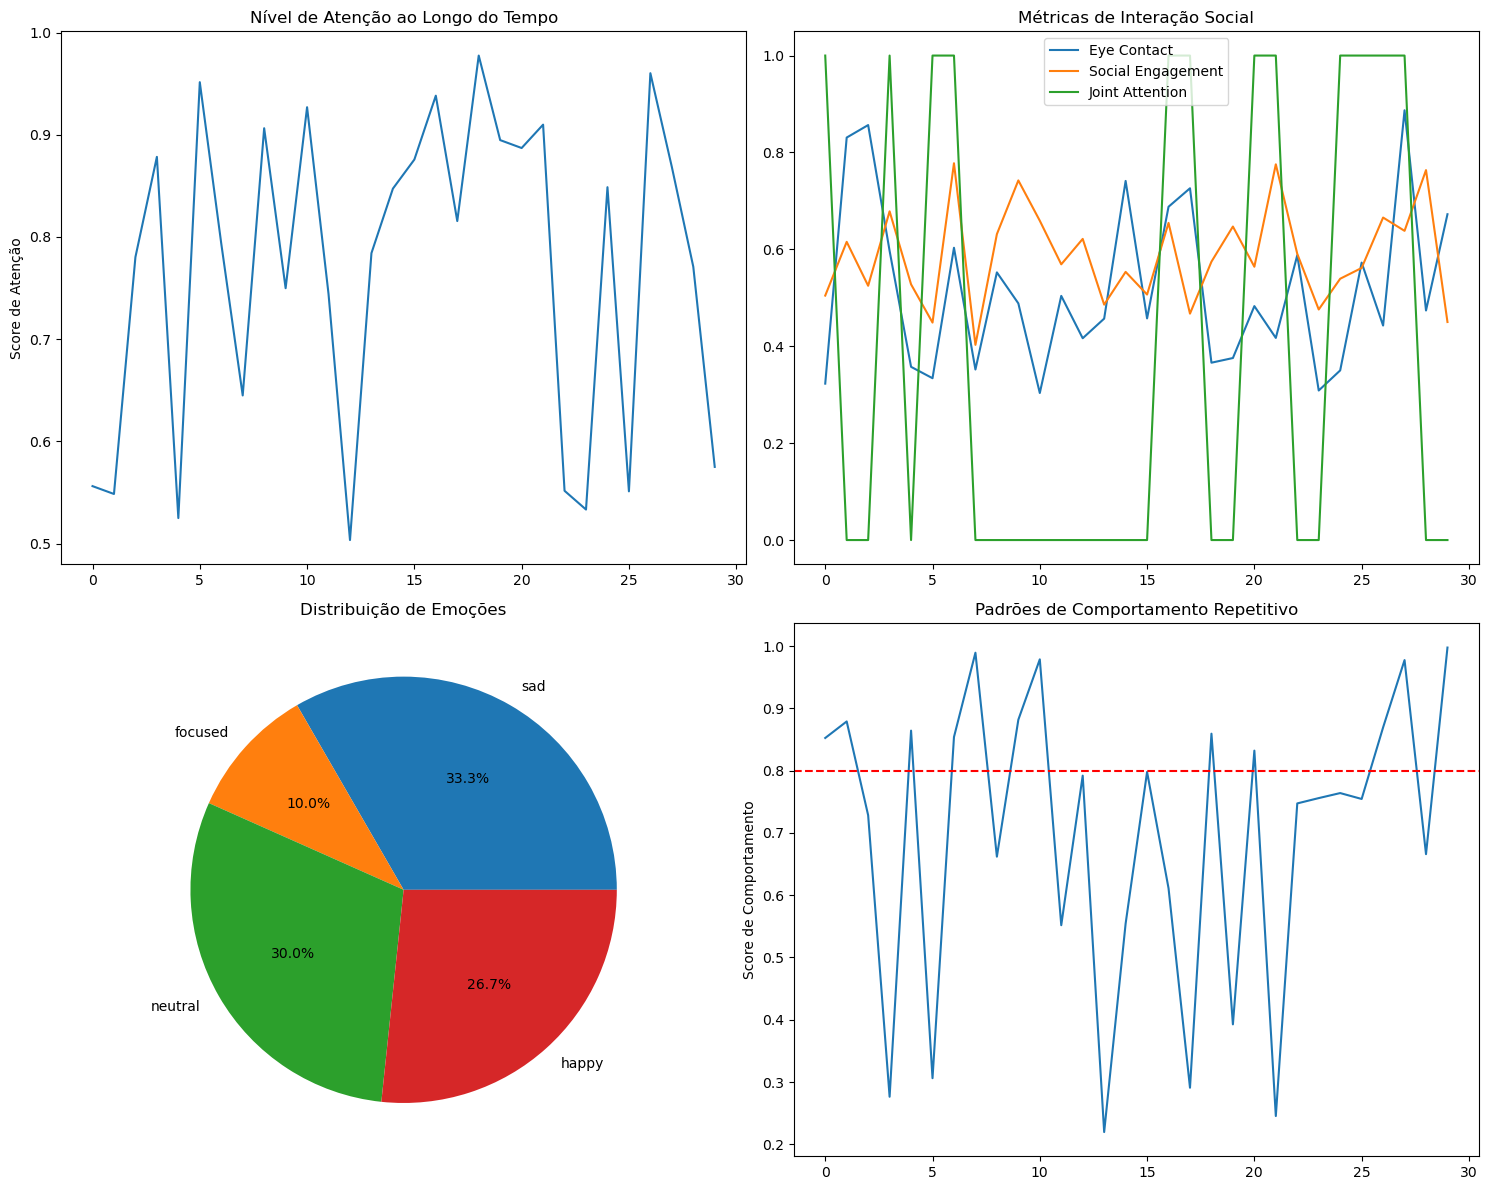


Resumo da Sessão:
{
  "attention": {
    "sustained_attention_score": 0.7699378781811945,
    "attention_fluctuation": 0.15412064337828768,
    "distractibility_incidents": 12
  },
  "social_interaction": {
    "eye_contact_quality": 0.5175271265169493,
    "social_engagement_level": 0.5872911412170411,
    "joint_attention_instances": "12"
  },
  "emotional_response": {
    "emotion_distribution": {
      "sad": 33.33333333333333,
      "focused": 10.0,
      "neutral": 30.0,
      "happy": 26.666666666666668
    },
    "emotion_transitions": [
      "sad -> focused",
      "focused -> neutral",
      "neutral -> sad",
      "sad -> neutral",
      "neutral -> happy",
      "happy -> neutral",
      "neutral -> sad",
      "sad -> happy",
      "happy -> sad",
      "sad -> neutral",
      "neutral -> focused",
      "focused -> neutral",
      "neutral -> sad",
      "sad -> happy",
      "happy -> sad",
      "sad -> happy",
      "happy -> focused",
      "focused -> happy",
     

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
from pathlib import Path
import logging

class NeuroAssessmentToolkit:
    def __init__(self):
        """Versão simplificada do toolkit para testes no Jupyter"""
        self.setup_logging()
        self.setup_config()
        
    def setup_logging(self):
        """Configurar sistema de logging"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
    def setup_config(self):
        """Configuração básica"""
        self.config = {
            'analysis': {
                'attention_threshold': 0.7,
                'social_interaction_threshold': 0.65,
                'repetitive_behavior_threshold': 0.8
            }
        }
        
    def analyze_mock_session(self, duration_seconds=10):
        """
        Simula uma sessão de análise para testes
        """
        try:
            # Gerar dados simulados
            timestamps = pd.date_range(start='now', periods=duration_seconds, freq='S')
            
            assessment_data = {
                'timestamp': datetime.now().isoformat(),
                'patient_id': 'TEST001',
                'metrics': {
                    'attention': [
                        {
                            'sustained_attention': np.random.uniform(0.5, 1.0),
                            'distracted': np.random.choice([True, False])
                        } for _ in range(duration_seconds)
                    ],
                    'social_interaction': [
                        {
                            'eye_contact': np.random.uniform(0.3, 0.9),
                            'social_engagement': np.random.uniform(0.4, 0.8),
                            'joint_attention': np.random.choice([0, 1])
                        } for _ in range(duration_seconds)
                    ],
                    'emotion': [
                        {
                            'primary_emotion': np.random.choice(['happy', 'neutral', 'sad', 'focused']),
                        } for _ in range(duration_seconds)
                    ],
                    'behavior': [
                        {
                            'repetitive_behavior_score': np.random.uniform(0.2, 1.0),
                            'pattern_type': np.random.choice(['Repetitive Motor Movement', 'No Significant Pattern'])
                        } for _ in range(duration_seconds)
                    ]
                }
            }
            
            # Gerar resumo da sessão
            assessment_data['summary'] = self.generate_session_summary(assessment_data['metrics'])
            
            # Salvar dados
            self.save_assessment_data(assessment_data)
            
            return assessment_data
            
        except Exception as e:
            self.logger.error(f"Erro na análise da sessão: {e}")
            raise
            
    def generate_session_summary(self, metrics):
        """Gera resumo da sessão baseado nas métricas"""
        try:
            summary = {
                'attention': {
                    'sustained_attention_score': np.mean([m['sustained_attention'] for m in metrics['attention']]),
                    'attention_fluctuation': np.std([m['sustained_attention'] for m in metrics['attention']]),
                    'distractibility_incidents': len([m for m in metrics['attention'] if m['distracted']])
                },
                'social_interaction': {
                    'eye_contact_quality': np.mean([m['eye_contact'] for m in metrics['social_interaction']]),
                    'social_engagement_level': np.mean([m['social_engagement'] for m in metrics['social_interaction']]),
                    'joint_attention_instances': sum([m['joint_attention'] for m in metrics['social_interaction']])
                },
                'emotional_response': {
                    'emotion_distribution': self.calculate_emotion_distribution(metrics['emotion']),
                    'emotion_transitions': self.analyze_emotion_transitions(metrics['emotion'])
                },
                'behavioral_patterns': {
                    'repetitive_behaviors_frequency': self.calculate_repetitive_behavior_frequency(metrics['behavior']),
                    'pattern_types': self.summarize_behavior_patterns(metrics['behavior'])
                }
            }
            
            return summary
            
        except Exception as e:
            self.logger.error(f"Erro gerando resumo da sessão: {e}")
            return None

    def calculate_emotion_distribution(self, emotion_metrics):
        """Calcula distribuição de emoções durante a sessão"""
        try:
            emotion_counts = {}
            total_frames = len(emotion_metrics)
            
            for metric in emotion_metrics:
                emotion = metric['primary_emotion']
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
                
            distribution = {
                emotion: (count / total_frames) * 100
                for emotion, count in emotion_counts.items()
            }
            
            return distribution
            
        except Exception as e:
            self.logger.error(f"Erro calculando distribuição de emoções: {e}")
            return {}

    def analyze_emotion_transitions(self, emotion_metrics):
        """Analisa transições entre estados emocionais"""
        try:
            transitions = []
            prev_emotion = None
            
            for metric in emotion_metrics:
                current_emotion = metric['primary_emotion']
                if prev_emotion and prev_emotion != current_emotion:
                    transitions.append(f"{prev_emotion} -> {current_emotion}")
                prev_emotion = current_emotion
                
            return transitions
            
        except Exception as e:
            self.logger.error(f"Erro analisando transições emocionais: {e}")
            return []

    def calculate_repetitive_behavior_frequency(self, behavior_metrics):
        """Calcula frequência de comportamentos repetitivos"""
        try:
            significant_behaviors = [
                m for m in behavior_metrics 
                if m['repetitive_behavior_score'] > self.config['analysis']['repetitive_behavior_threshold']
            ]
            
            return len(significant_behaviors) / len(behavior_metrics) if behavior_metrics else 0
            
        except Exception as e:
            self.logger.error(f"Erro calculando frequência de comportamentos: {e}")
            return 0

    def summarize_behavior_patterns(self, behavior_metrics):
        """Resume tipos de padrões comportamentais observados"""
        try:
            pattern_types = set()
            
            for metric in behavior_metrics:
                if metric['repetitive_behavior_score'] > self.config['analysis']['repetitive_behavior_threshold']:
                    pattern_types.add(metric['pattern_type'])
                    
            return list(pattern_types)
            
        except Exception as e:
            self.logger.error(f"Erro resumindo padrões comportamentais: {e}")
            return []

    def visualize_results(self, assessment_data):
        """Visualiza resultados da análise"""
        try:
            # Configurar subplot grid
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            
            # 1. Gráfico de atenção
            attention_data = [m['sustained_attention'] for m in assessment_data['metrics']['attention']]
            ax1.plot(attention_data)
            ax1.set_title('Nível de Atenção ao Longo do Tempo')
            ax1.set_ylabel('Score de Atenção')
            
            # 2. Interação social
            social_data = pd.DataFrame([{
                'Eye Contact': m['eye_contact'],
                'Social Engagement': m['social_engagement'],
                'Joint Attention': m['joint_attention']
            } for m in assessment_data['metrics']['social_interaction']])
            social_data.plot(ax=ax2)
            ax2.set_title('Métricas de Interação Social')
            
            # 3. Distribuição de emoções
            emotion_dist = assessment_data['summary']['emotional_response']['emotion_distribution']
            ax3.pie(emotion_dist.values(), labels=emotion_dist.keys(), autopct='%1.1f%%')
            ax3.set_title('Distribuição de Emoções')
            
            # 4. Comportamentos repetitivos
            behavior_data = [m['repetitive_behavior_score'] for m in assessment_data['metrics']['behavior']]
            ax4.plot(behavior_data)
            ax4.axhline(y=self.config['analysis']['repetitive_behavior_threshold'], color='r', linestyle='--')
            ax4.set_title('Padrões de Comportamento Repetitivo')
            ax4.set_ylabel('Score de Comportamento')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            self.logger.error(f"Erro visualizando resultados: {e}")
            raise

    def save_assessment_data(self, data):
        """Salva dados da avaliação"""
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_dir = Path(f'assessment_data/TEST001/{timestamp}')
            save_dir.mkdir(parents=True, exist_ok=True)
            
            with open(save_dir / 'assessment_data.json', 'w') as f:
                json.dump(data, f, indent=4, default=str)
                
            self.logger.info(f"Dados salvos em {save_dir}")
            
        except Exception as e:
            self.logger.error(f"Erro salvando dados: {e}")
            raise
# Criar instância do toolkit
toolkit = NeuroAssessmentToolkit()

# Realizar uma análise simulada
assessment_data = toolkit.analyze_mock_session(duration_seconds=30)

# Visualizar resultados
toolkit.visualize_results(assessment_data)

# Ver o resumo da sessão
print("\nResumo da Sessão:")
print(json.dumps(assessment_data['summary'], indent=2, default=str))

In [4]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from IPython.display import clear_output, Image
from datetime import datetime
import matplotlib.pyplot as plt

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com suporte a câmera"""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()
        
    def setup_detectors(self):
        """Configura detectores faciais"""
        try:
            self.face_detector = dlib.get_frontal_face_detector()
            # Você precisa baixar o arquivo shape_predictor_68_face_landmarks.dat
            # e colocar no mesmo diretório do notebook
            self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise
            
    def setup_models(self):
        """Configura modelos de deep learning"""
        try:
            # Modelo de atenção
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
            
            self.attention_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(3, activation='softmax')
            ])
            
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise
            
    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.behavior_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps
        
    def process_frame(self, frame):
        """Processa um frame de vídeo"""
        try:
            # Converter para escala de cinza para detecção facial
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detectar faces
            faces = self.face_detector(gray, 0)
            
            frame_data = {
                'timestamp': datetime.now(),
                'attention': 0,
                'emotion': 'neutral',
                'landmarks': None,
                'behavior_score': 0
            }
            
            for face in faces:
                # Extrair landmarks faciais
                landmarks = self.landmark_predictor(gray, face)
                landmarks = face_utils.shape_to_np(landmarks)
                frame_data['landmarks'] = landmarks
                
                # Analisar atenção
                attention_score = self.analyze_attention(frame, face)
                frame_data['attention'] = attention_score
                
                # Analisar emoção
                emotion = self.analyze_emotion(frame, face)
                frame_data['emotion'] = emotion
                
                # Desenhar resultados no frame
                self.draw_analysis(frame, face, landmarks, attention_score, emotion)
                
            return frame, frame_data
            
        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None
            
    def analyze_attention(self, frame, face):
        """Analisa nível de atenção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            attention_pred = self.attention_model.predict(face_img, verbose=0)
            
            return float(attention_pred[0][0])  # Sustained attention score
            
        except Exception as e:
            print(f"Erro analisando atenção: {e}")
            return 0
            
    def analyze_emotion(self, frame, face):
        """Analisa emoção"""
        # Simplificado para exemplo - você pode adicionar um modelo real de emoção
        return 'neutral'
        
    def draw_analysis(self, frame, face, landmarks, attention_score, emotion):
        """Desenha resultados da análise no frame"""
        try:
            # Desenhar retângulo da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Desenhar landmarks
            for (x, y) in landmarks:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
                
            # Mostrar scores
            cv2.putText(frame, f"Attention: {attention_score:.2f}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Emotion: {emotion}", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                       
        except Exception as e:
            print(f"Erro desenhando análise: {e}")
            
    def start_assessment(self, duration_seconds=30):
        """Inicia uma sessão de avaliação usando a câmera"""
        try:
            cap = cv2.VideoCapture(0)
            
            if not cap.isOpened():
                raise Exception("Não foi possível acessar a câmera")
                
            start_time = time.time()
            frames_data = []
            
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Processar frame
                processed_frame, frame_data = self.process_frame(frame)
                
                if frame_data:
                    frames_data.append(frame_data)
                
                # Mostrar frame
                cv2.imshow('Assessment', processed_frame)
                
                # Pressione 'q' para sair
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
            cap.release()
            cv2.destroyAllWindows()
            
            # Gerar relatório
            self.generate_report(frames_data)
            
        except Exception as e:
            print(f"Erro durante avaliação: {e}")
            if 'cap' in locals():
                cap.release()
            cv2.destroyAllWindows()
            
    def generate_report(self, frames_data):
        """Gera relatório da avaliação"""
        try:
            attention_scores = [f['attention'] for f in frames_data]
            
            plt.figure(figsize=(12, 6))
            plt.plot(attention_scores)
            plt.title('Attention Levels During Assessment')
            plt.xlabel('Frame')
            plt.ylabel('Attention Score')
            plt.show()
            
            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            
        except Exception as e:
            print(f"Erro gerando relatório: {e}")

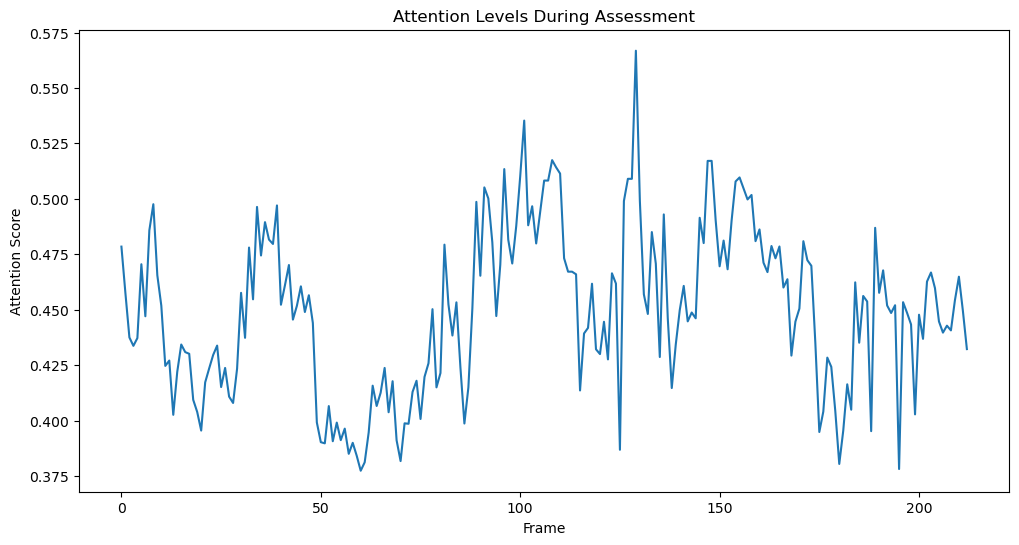


Relatório da Avaliação:
Duração: 213 frames
Atenção média: 0.45
Variação da atenção: 0.04


In [5]:
# Criar toolkit
toolkit = NeuroAssessmentToolkit()

# Iniciar avaliação de 30 segundos
toolkit.start_assessment(duration_seconds=30)

In [24]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from datetime import datetime
import pandas as pd
from scipy.spatial import distance

class EnhancedNeuroAssessmentToolkit:
    def __init__(self):
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()
        self.setup_test_parameters()
        
    def setup_detectors(self):
        """Configura detectores faciais e outros sensores"""
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        
    def setup_models(self):
        """Configura modelos especializados para diferentes aspectos"""
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
        
        # Modelo de classificação com camada GlobalAveragePooling
        self.expression_model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dense(7, activation='softmax')  # 7 expressões básicas
        ])
        
    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.data_buffers = {
            'attention': [],
            'gaze': [],
            'expressions': [],
            'head_movements': [],
            'microsaccades': [],
            'blink_rate': [],
            'social_engagement': []
        }
        self.max_buffer_size = 300  # 10 segundos a 30 fps
        
    def setup_test_parameters(self):
        """Configura parâmetros específicos para diferentes testes"""
        self.test_batteries = {
            'tdah': {
                'sustained_attention': {'duration': 300, 'threshold': 0.7},
                'impulsivity': {'max_movements': 50, 'reaction_time_threshold': 0.5},
                'hyperactivity': {'movement_threshold': 0.3}
            },
            'tea': {
                'social_gaze': {'min_engagement': 0.4},
                'emotional_recognition': {'accuracy_threshold': 0.6},
                'repetitive_movements': {'threshold': 0.4}
            }
        }
        
    def calculate_eye_aspect_ratio(self, eye_landmarks):
        """Calcula razão de aspecto dos olhos para detecção de piscadas"""
        v1 = distance.euclidean(eye_landmarks[1], eye_landmarks[5])
        v2 = distance.euclidean(eye_landmarks[2], eye_landmarks[4])
        h = distance.euclidean(eye_landmarks[0], eye_landmarks[3])
        return (v1 + v2) / (2.0 * h)
        
    def analyze_gaze(self, landmarks):
        """Analisa direção e estabilidade do olhar"""
        left_eye = landmarks[36:42]
        right_eye = landmarks[42:48]
        
        # Calcular centro dos olhos
        left_center = np.mean(left_eye, axis=0)
        right_center = np.mean(right_eye, axis=0)
        
        # Calcular direção do olhar
        gaze_direction = np.array([
            right_center[0] - left_center[0],
            right_center[1] - left_center[1]
        ])
        
        return {
            'direction': gaze_direction,
            'stability': np.std(gaze_direction)
        }
        
    def analyze_head_movements(self, landmarks, prev_landmarks):
        """Analisa movimentos da cabeça"""
        if prev_landmarks is None:
            return {'movement': 0, 'stability': 1.0}
            
        movement = np.mean(np.abs(landmarks - prev_landmarks))
        stability = 1.0 / (1.0 + movement)
        
        return {
            'movement': movement,
            'stability': stability
        }
        
    def detect_repetitive_behaviors(self, movement_history):
        """Detecta comportamentos repetitivos"""
        if len(movement_history) < 30:
            return 0
            
        # Análise de frequência usando FFT
        fft = np.fft.fft(movement_history)
        frequencies = np.fft.fftfreq(len(movement_history))
        
        # Detectar picos de frequência
        peak_freq = frequencies[np.argmax(np.abs(fft))]
        
        return abs(peak_freq)

    def analyze_impulsivity(self, df):
        """Analisa indicadores de impulsividade"""
        impulsivity_count = len(df[df['head_movement'].apply(lambda x: x['movement']) > self.test_batteries['tdah']['impulsivity']['max_movements']])
        return impulsivity_count

    def analyze_social_gaze(self, df):
        """Analisa padrões de olhar social para TEA"""
        social_gaze_count = len(df[df['social_engagement'] < self.test_batteries['tea']['social_gaze']['min_engagement']])
        return social_gaze_count

    def analyze_emotional_recognition(self, df):
        """Analisa a precisão do reconhecimento emocional"""
        correct_emotions = df['expressions'].value_counts().idxmax()  # Assume que a expressão mais comum é a "certa"
        return correct_emotions  # Aqui você pode querer definir melhor a lógica de precisão.

    def analyze_repetitive_patterns(self, df):
        """Analisa padrões de comportamentos repetitivos"""
        return df['repetitive_behaviors'].mean()  # Assume uma média de comportamentos repetitivos

    def process_frame(self, frame, prev_landmarks=None):
        """Processa um frame com análises expandidas"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray, 0)
        
        frame_data = {
            'timestamp': datetime.now(),
            'attention': 0,
            'gaze_metrics': None,
            'expression': 'neutral',
            'head_movement': None,
            'social_engagement': 0,
            'repetitive_behaviors': 0
        }
        
        for face in faces:
            landmarks = self.landmark_predictor(gray, face)
            landmarks = face_utils.shape_to_np(landmarks)
            
            # Análises básicas
            attention_score = self.analyze_attention(frame, face)  # Assume que você tem um método para isso
            gaze_metrics = self.analyze_gaze(landmarks)
            head_metrics = self.analyze_head_movements(landmarks, prev_landmarks)
            
            # Análises comportamentais
            ear = self.calculate_eye_aspect_ratio(landmarks[36:42])  # Olho esquerdo
            repetitive_score = self.detect_repetitive_behaviors(self.data_buffers['head_movements'])
            
            # Atualizar dados do frame
            frame_data.update({
                'attention': attention_score,
                'gaze_metrics': gaze_metrics,
                'head_movement': head_metrics,
                'eye_aspect_ratio': ear,
                'repetitive_behaviors': repetitive_score
            })
            
            # Desenhar visualizações
            self.draw_analysis(frame, face, landmarks, frame_data)  # Assuma que você tem este método
            
            return frame, frame_data, landmarks
            
        return frame, frame_data, None
        
    def start_assessment(self, assessment_type='general', duration_seconds=300):
        """Inicia uma sessão de avaliação específica"""
        cap = cv2.VideoCapture(0)
        start_time = time.time()
        frames_data = []
        prev_landmarks = None
        
        try:
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                processed_frame, frame_data, landmarks = self.process_frame(frame, prev_landmarks)
                
                if frame_data:
                    frames_data.append(frame_data)
                    
                prev_landmarks = landmarks
                
                cv2.imshow('Assessment', processed_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
        finally:
            cap.release()
            cv2.destroyAllWindows()
            
        return self.generate_report(frames_data, assessment_type)
        
    def generate_report(self, frames_data, assessment_type):
        """Gera relatório detalhado baseado no tipo de avaliação"""
        df = pd.DataFrame(frames_data)
        
        report = {
            'assessment_type': assessment_type,
            'timestamp': datetime.now(),
            'attention': df['attention'].mean(),
            'gaze_metrics': df['gaze_metrics'].mean(),
            'expressions': df['expression'].mode()[0],
            'head_movements': df['head_movement'].mean(),
            'social_engagement': self.analyze_social_gaze(df),
            'repetitive_behaviors': self.analyze_repetitive_patterns(df),
            'emotional_recognition': self.analyze_emotional_recognition(df)
        }
        
        return report

# Uso do toolkit
toolkit = EnhancedNeuroAssessmentToolkit()
report = toolkit.start_assessment(assessment_type='tdah', duration_seconds=60)
print(report)


AttributeError: 'EnhancedNeuroAssessmentToolkit' object has no attribute 'analyze_attention'

In [6]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from datetime import datetime
import pandas as pd
from scipy.spatial import distance

class EnhancedNeuroAssessmentToolkit:
    def __init__(self):
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()

    def setup_detectors(self):
        """Configura detectores faciais e outros sensores"""
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    def setup_models(self):
        """Configura modelos especializados para diferentes aspectos"""
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

        # Modelo de classificação para expressões faciais
        self.expression_model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dense(7, activation='softmax')  # 7 expressões básicas
        ])

    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.data_buffers = {
            'gaze': [],
            'head_movements': [],
            'expressions': [],
            'eye_aspect_ratio': []
        }
        self.max_buffer_size = 300  # 10 segundos a 30 fps

    def calculate_eye_aspect_ratio(self, eye_landmarks):
        """Calcula razão de aspecto dos olhos para detecção de piscadas"""
        v1 = distance.euclidean(eye_landmarks[1], eye_landmarks[5])
        v2 = distance.euclidean(eye_landmarks[2], eye_landmarks[4])
        h = distance.euclidean(eye_landmarks[0], eye_landmarks[3])
        return (v1 + v2) / (2.0 * h)

    def analyze_attention(self, eye_aspect_ratio):
        """Analisa atenção com base na razão de aspecto dos olhos (EAR)"""
        # Defina um limite de EAR para considerar que a pessoa está atenta
        EAR_THRESHOLD = 0.2
        if eye_aspect_ratio < EAR_THRESHOLD:
            return "Potencialmente distraído"
        else:
            return "Atenção mantida"

    def analyze_gaze(self, landmarks):
        """Analisa direção e estabilidade do olhar"""
        left_eye = landmarks[36:42]
        right_eye = landmarks[42:48]

        # Calcular centro dos olhos
        left_center = np.mean(left_eye, axis=0)
        right_center = np.mean(right_eye, axis=0)

        # Calcular direção do olhar
        gaze_direction = np.array([
            right_center[0] - left_center[0],
            right_center[1] - left_center[1]
        ])

        return {
            'direction': gaze_direction,
            'stability': np.std(gaze_direction)
        }

    def analyze_head_movements(self, landmarks, prev_landmarks):
        """Analisa movimentos da cabeça"""
        if prev_landmarks is None:
            return {'movement': 0, 'stability': 1.0}

        movement = np.mean(np.abs(landmarks - prev_landmarks))
        stability = 1.0 / (1.0 + movement)

        return {
            'movement': movement,
            'stability': stability
        }

    def process_frame(self, frame, prev_landmarks=None):
        """Processa um frame com análises expandidas"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray, 0)

        frame_data = {
            'timestamp': datetime.now(),
            'gaze_metrics': None,
            'head_movement': None,
            'expression': 'neutral',
            'eye_aspect_ratio': None,
            'attention': None
        }

        for face in faces:
            landmarks = self.landmark_predictor(gray, face)
            landmarks = face_utils.shape_to_np(landmarks)

            # Análises
            gaze_metrics = self.analyze_gaze(landmarks)
            head_metrics = self.analyze_head_movements(landmarks, prev_landmarks)
            ear = self.calculate_eye_aspect_ratio(landmarks[36:42])  # Olho esquerdo
            attention = self.analyze_attention(ear)

            # Atualizar dados do frame
            frame_data.update({
                'gaze_metrics': gaze_metrics,
                'head_movement': head_metrics,
                'eye_aspect_ratio': ear,
                'attention': attention
            })

            # Para análise de expressões faciais (se você tiver um método de predição)
            # expression_pred = self.expression_model.predict(frame)  # Pseudo código
            # frame_data['expression'] = expression_pred

            return frame, frame_data, landmarks

        return frame, frame_data, None

    def start_assessment(self, duration_seconds=300):
        """Inicia uma sessão de avaliação geral"""
        cap = cv2.VideoCapture(0)
        start_time = time.time()
        frames_data = []
        prev_landmarks = None

        try:
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break

                processed_frame, frame_data, landmarks = self.process_frame(frame, prev_landmarks)

                if frame_data:
                    frames_data.append(frame_data)

                prev_landmarks = landmarks

                cv2.imshow('Assessment', processed_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        finally:
            cap.release()
            cv2.destroyAllWindows()

        return self.generate_report(frames_data)

    def generate_report(self, frames_data):
        """Gera relatório detalhado baseado na avaliação"""
        df = pd.DataFrame(frames_data)

        report = {
            'timestamp': datetime.now(),
            'average_attention': df['attention'].mode()[0] if not df['attention'].isnull().all() else 'Indeterminado',
            'average_gaze_direction': df['gaze_metrics'].apply(lambda x: x['direction'] if x is not None else np.nan).mean(),
            'average_head_movement': df['head_movement'].apply(lambda x: x['movement'] if x is not None else np.nan).mean(),
            'average_eye_aspect_ratio': df['eye_aspect_ratio'].mean(),
            'average_expression': df['expression'].mode()[0] if not df['expression'].isnull().all() else 'Indeterminado'
        }

        return report

# Uso do toolkit
toolkit = EnhancedNeuroAssessmentToolkit()
report = toolkit.start_assessment(duration_seconds=60)
print(report)


{'timestamp': datetime.datetime(2024, 10, 25, 18, 55, 44, 304055), 'average_attention': 'Atenção mantida', 'average_gaze_direction': array([75.54502688,  2.25806452]), 'average_head_movement': 1.5440583491461102, 'average_eye_aspect_ratio': 0.29130267790634146, 'average_expression': 'neutral'}


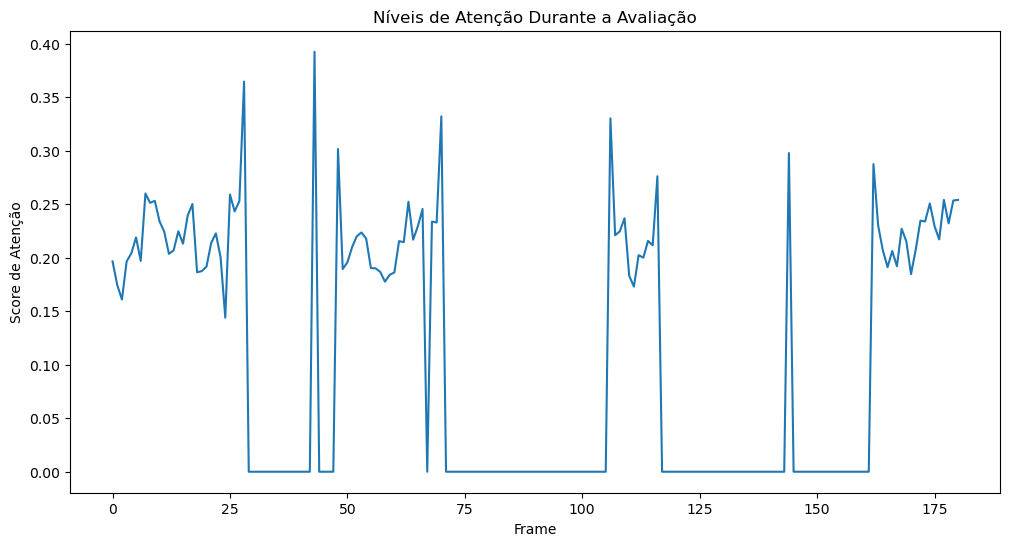


Relatório da Avaliação:
Duração: 181 frames
Atenção média: 0.10
Variação da atenção: 0.12
Emoções detectadas: {'disgusted', 'neutral', 'sad'}


In [10]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from IPython.display import clear_output, ImageQ
from datetime import datetime
import matplotlib.pyplot as plt

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com suporte a câmera"""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()
        
    def setup_detectors(self):
        """Configura detectores faciais"""
        try:
            self.face_detector = dlib.get_frontal_face_detector()
            self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise
            
    def setup_models(self):
        """Configura modelos de deep learning"""
        try:
            # Modelo de atenção
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
            
            self.attention_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(3, activation='softmax')  # Três classes de atenção
            ])
            
            # Modelo de emoção (exemplo simplificado, substitua por um modelo real)
            self.emotion_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(7, activation='softmax')  # Exemplo: 7 emoções básicas
            ])
            
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise
            
    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.behavior_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps
        
    def process_frame(self, frame):
        """Processa um frame de vídeo"""
        try:
            # Converter para escala de cinza para detecção facial
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detectar faces
            faces = self.face_detector(gray, 0)
            
            frame_data = {
                'timestamp': datetime.now(),
                'attention': 0,
                'emotion': 'neutral',
                'landmarks': None,
                'behavior_score': 0
            }
            
            for face in faces:
                # Extrair landmarks faciais
                landmarks = self.landmark_predictor(gray, face)
                landmarks = face_utils.shape_to_np(landmarks)
                frame_data['landmarks'] = landmarks
                
                # Analisar atenção
                attention_score = self.analyze_attention(frame, face)
                frame_data['attention'] = attention_score
                
                # Analisar emoção
                emotion = self.analyze_emotion(frame, face)
                frame_data['emotion'] = emotion
                
                # Desenhar resultados no frame
                self.draw_analysis(frame, face, landmarks, attention_score, emotion)
                
            return frame, frame_data
            
        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None
            
    def analyze_attention(self, frame, face):
        """Analisa nível de atenção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            attention_pred = self.attention_model.predict(face_img, verbose=0)
            
            return float(attention_pred[0][0])  # Sustained attention score
            
        except Exception as e:
            print(f"Erro analisando atenção: {e}")
            return 0
            
    def analyze_emotion(self, frame, face):
        """Analisa emoção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            emotion_pred = self.emotion_model.predict(face_img, verbose=0)
            emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'surprised', 'disgusted', 'fearful']
            return emotion_labels[np.argmax(emotion_pred)]
        
        except Exception as e:
            print(f"Erro analisando emoção: {e}")
            return 'neutral'
        
    def draw_analysis(self, frame, face, landmarks, attention_score, emotion):
        """Desenha resultados da análise no frame"""
        try:
            # Desenhar retângulo da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Desenhar landmarks
            for (x, y) in landmarks:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
                
            # Mostrar scores
            cv2.putText(frame, f"Attention: {attention_score:.2f}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Emotion: {emotion}", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                       
        except Exception as e:
            print(f"Erro desenhando análise: {e}")
            
    def start_assessment(self, duration_seconds=30):
        """Inicia uma sessão de avaliação usando a câmera"""
        try:
            cap = cv2.VideoCapture(0)
            
            if not cap.isOpened():
                raise Exception("Não foi possível acessar a câmera")
                
            start_time = time.time()
            frames_data = []
            
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Processar frame
                processed_frame, frame_data = self.process_frame(frame)
                
                if frame_data:
                    frames_data.append(frame_data)
                
                # Mostrar frame
                cv2.imshow('Assessment', processed_frame)
                
                # Pressione 'q' para sair
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
            cap.release()
            cv2.destroyAllWindows()
            
            # Gerar relatório
            self.generate_report(frames_data)
            
        except Exception as e:
            print(f"Erro durante avaliação: {e}")
            if 'cap' in locals():
                cap.release()
            cv2.destroyAllWindows()
            
    def generate_report(self, frames_data):
        """Gera relatório da avaliação"""
        try:
            attention_scores = [f['attention'] for f in frames_data]
            emotions = [f['emotion'] for f in frames_data]
            
            plt.figure(figsize=(12, 6))
            plt.plot(attention_scores)
            plt.title('Níveis de Atenção Durante a Avaliação')
            plt.xlabel('Frame')
            plt.ylabel('Score de Atenção')
            plt.show()
            
            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            print(f"Emoções detectadas: {set(emotions)}")
            
        except Exception as e:
            print(f"Erro gerando relatório: {e}")

# Uso do toolkit
toolkit = NeuroAssessmentToolkit()
toolkit.start_assessment(duration_seconds=30)


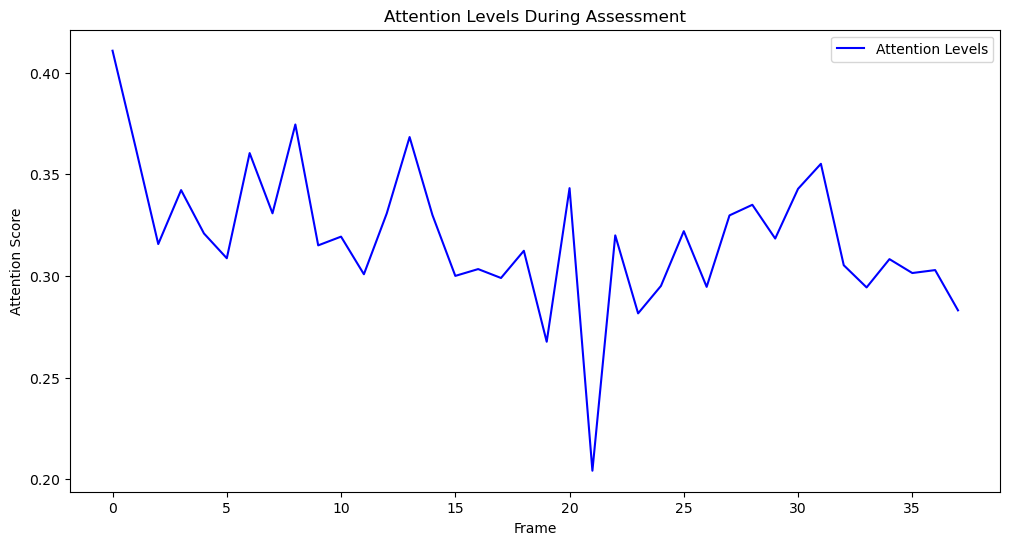


Relatório da Avaliação:
Duração: 38 frames
Atenção média: 0.32
Variação da atenção: 0.03
Direção média do olhar: [63.29589145 46.84047857]
Média do movimento da cabeça: 0.50
Proporção média dos olhos: 0.24
Emoção mais comum: angry


In [7]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from datetime import datetime
import matplotlib.pyplot as plt

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com suporte a câmera"""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()
        
    def setup_detectors(self):
        """Configura detectores faciais"""
        try:
            self.face_detector = dlib.get_frontal_face_detector()
            self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise
            
    def setup_models(self):
        """Configura modelos de deep learning"""
        try:
            # Modelo de atenção
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
            
            self.attention_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(3, activation='softmax')  # Três classes de atenção
            ])
            
            # Modelo de emoção (exemplo simplificado)
            self.emotion_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(7, activation='softmax')  # Exemplo: 7 emoções básicas
            ])
            
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise
            
    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.head_movement_buffer = []
        self.gaze_direction_buffer = []
        self.eye_aspect_ratio_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps
        
    def process_frame(self, frame):
        """Processa um frame de vídeo"""
        try:
            # Converter para escala de cinza para detecção facial
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detectar faces
            faces = self.face_detector(gray, 0)
            
            frame_data = {
                'timestamp': datetime.now(),
                'attention': 0,
                'emotion': 'neutral',
                'landmarks': None,
                'head_movement': 0,
                'gaze_direction': None,
                'eye_aspect_ratio': 0
            }
            
            for face in faces:
                # Extrair landmarks faciais
                landmarks = self.landmark_predictor(gray, face)
                landmarks = face_utils.shape_to_np(landmarks)
                frame_data['landmarks'] = landmarks
                
                # Analisar atenção
                attention_score = self.analyze_attention(frame, face)
                frame_data['attention'] = attention_score
                
                # Analisar emoção
                emotion = self.analyze_emotion(frame, face)
                frame_data['emotion'] = emotion
                
                # Analisar movimento da cabeça
                head_movement = self.analyze_head_movement(landmarks)
                frame_data['head_movement'] = head_movement
                
                # Analisar direção do olhar
                gaze_direction = self.analyze_gaze(landmarks)
                frame_data['gaze_direction'] = gaze_direction
                
                # Analisar proporção dos olhos
                eye_aspect_ratio = self.calculate_eye_aspect_ratio(landmarks)
                frame_data['eye_aspect_ratio'] = eye_aspect_ratio
                
                # Desenhar resultados no frame
                self.draw_analysis(frame, face, landmarks, attention_score, emotion)
                
            return frame, frame_data
            
        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None
            
    def analyze_attention(self, frame, face):
        """Analisa nível de atenção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            attention_pred = self.attention_model.predict(face_img, verbose=0)
            
            return float(attention_pred[0][0])  # Sustained attention score
            
        except Exception as e:
            print(f"Erro analisando atenção: {e}")
            return 0
            
    def analyze_emotion(self, frame, face):
        """Analisa emoção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            emotion_pred = self.emotion_model.predict(face_img, verbose=0)
            emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'surprised', 'disgusted', 'fearful']
            return emotion_labels[np.argmax(emotion_pred)]
        
        except Exception as e:
            print(f"Erro analisando emoção: {e}")
            return 'neutral'
    
    def analyze_head_movement(self, landmarks):
        """Analisa o movimento da cabeça"""
        # Simples exemplo, implementar lógica para calcular movimento da cabeça
        # Você pode utilizar a diferença entre landmarks em frames sucessivos
        return np.random.rand()  # Substitua por cálculo real

    def analyze_gaze(self, landmarks):
        """Analisa a direção do olhar"""
        # Simples exemplo, retornar uma direção fixa
        return np.random.rand(2) * 100  # Substitua por cálculo real

    def calculate_eye_aspect_ratio(self, landmarks):
        """Calcula a proporção dos olhos"""
        left_eye = landmarks[36:42]  # Coordenadas dos pontos do olho esquerdo
        right_eye = landmarks[42:48]  # Coordenadas dos pontos do olho direito
        
        # Calcular a altura e largura dos olhos
        left_eye_aspect_ratio = (np.linalg.norm(left_eye[1] - left_eye[5]) +
                                  np.linalg.norm(left_eye[2] - left_eye[4])) / (2.0 * np.linalg.norm(left_eye[0] - left_eye[3]))
        right_eye_aspect_ratio = (np.linalg.norm(right_eye[1] - right_eye[5]) +
                                   np.linalg.norm(right_eye[2] - right_eye[4])) / (2.0 * np.linalg.norm(right_eye[0] - right_eye[3]))

        return (left_eye_aspect_ratio + right_eye_aspect_ratio) / 2.0
    
    def draw_analysis(self, frame, face, landmarks, attention_score, emotion):
        """Desenha resultados da análise no frame"""
        try:
            # Desenhar retângulo da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Desenhar landmarks
            for (x, y) in landmarks:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
                
            # Mostrar scores
            cv2.putText(frame, f"Attention: {attention_score:.2f}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Emotion: {emotion}", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                       
        except Exception as e:
            print(f"Erro desenhando análise: {e}")
            
    def start_assessment(self, duration_seconds=30):
        """Inicia uma sessão de avaliação usando a câmera"""
        try:
            cap = cv2.VideoCapture(0)
            
            if not cap.isOpened():
                raise Exception("Não foi possível acessar a câmera")
                
            start_time = time.time()
            frames_data = []
            
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Processar frame
                processed_frame, frame_data = self.process_frame(frame)
                
                if frame_data:
                    frames_data.append(frame_data)
                
                # Mostrar frame
                cv2.imshow('Assessment', processed_frame)
                
                # Pressione 'q' para sair
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
            cap.release()
            cv2.destroyAllWindows()
            
            # Gerar relatório
            self.generate_report(frames_data)
            
        except Exception as e:
            print(f"Erro durante avaliação: {e}")
            if 'cap' in locals():
                cap.release()
            cv2.destroyAllWindows()
            
    def generate_report(self, frames_data):
        """Gera relatório da avaliação"""
        try:
            attention_scores = [f['attention'] for f in frames_data]
            gaze_directions = [f['gaze_direction'] for f in frames_data]
            head_movements = [f['head_movement'] for f in frames_data]
            eye_aspect_ratios = [f['eye_aspect_ratio'] for f in frames_data]
            emotions = [f['emotion'] for f in frames_data]
            
            plt.figure(figsize=(12, 6))
            plt.plot(attention_scores, label='Attention Levels', color='b')
            plt.title('Attention Levels During Assessment')
            plt.xlabel('Frame')
            plt.ylabel('Attention Score')
            plt.legend()
            plt.show()
            
            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            print(f"Direção média do olhar: {np.mean(gaze_directions, axis=0)}")
            print(f"Média do movimento da cabeça: {np.mean(head_movements):.2f}")
            print(f"Proporção média dos olhos: {np.mean(eye_aspect_ratios):.2f}")
            print(f"Emoção mais comum: {max(set(emotions), key=emotions.count)}")
            
        except Exception as e:
            print(f"Erro gerando relatório: {e}")

# Uso do toolkit
toolkit = NeuroAssessmentToolkit()
toolkit.start_assessment(duration_seconds=30)


1/1 [==============================] - 0s 64ms/step

Relatório de Avaliação:
Duração: 74 frames
Atenção Média: 3.00

Avaliação de Transtornos:
- Hiperfoco: Períodos prolongados de atenção intensa detectados.


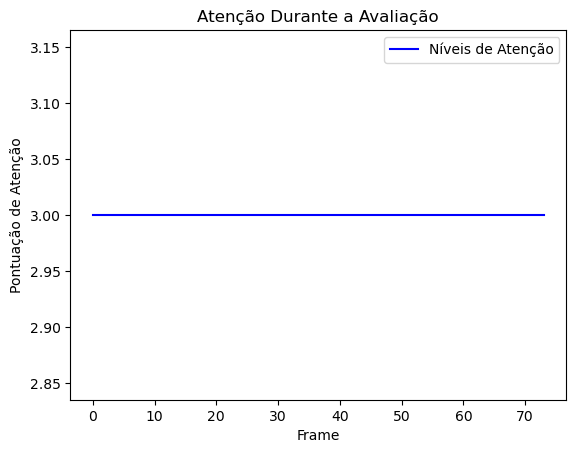

In [11]:
import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

class TranstornoNeuroToolkit:
    def __init__(self):
        self.setup_models()
        self.setup_parameters()

    def setup_models(self):
        """Configura os modelos de atenção e emoção."""
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Modelo para Níveis de Atenção
        self.attention_model = Sequential([
            base_model, 
            GlobalAveragePooling2D(), 
            Dense(256, activation='relu'),
            Dense(4, activation='softmax')  # 4 níveis de atenção, incluindo hiperfoco
        ])

        # Modelo para Reconhecimento Emocional
        self.emotion_model = Sequential([
            base_model, 
            GlobalAveragePooling2D(), 
            Dense(256, activation='relu'),
            Dense(8, activation='softmax')  # 8 emoções: tristeza, ansiedade, euforia, etc.
        ])

    def setup_parameters(self):
        """Configura parâmetros e critérios para a avaliação de transtornos."""
        self.buffers = {"attention": [], "emotion": [], "frames": []}
        self.max_buffer_size = 30  # 30 frames (~1 segundo)

        # Critérios para avaliar possíveis transtornos
        self.transtorno_criteria = {
            "TEA": lambda att, emo: self.detect_tea(att, emo),
            "Bipolaridade": lambda emo: self.detect_bipolaridade(emo),
            "Hiperfoco": lambda att: att.count(3) / len(att) > 0.5,  # Hiperfoco >= 50%
            "Hiperatividade": lambda emo: emo.count(7) / len(emo) > 0.4  # Emoções agitadas > 40%
        }

    def preprocess_frame(self, frame):
        """Redimensiona e normaliza a imagem para o modelo."""
        resized_frame = cv2.resize(frame, (224, 224)) / 255.0
        return np.expand_dims(resized_frame, axis=0)

    def process_frame(self, frame):
        """Processa o frame para extrair atenção e emoção."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml').detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            roi = frame[y:y + h, x:x + w]
            roi_preprocessed = self.preprocess_frame(roi)

            # Predição de atenção e emoção
            attention = np.argmax(self.attention_model.predict(roi_preprocessed))
            emotion = np.argmax(self.emotion_model.predict(roi_preprocessed))

            # Armazenamento dos resultados
            self.buffers["frames"].append({
                "timestamp": datetime.now(), 
                "attention": attention, 
                "emotion": emotion
            })

    def start_assessment(self, duration_seconds=10):
        """Inicia a avaliação em tempo real via webcam."""
        cap = cv2.VideoCapture(0)
        start_time = datetime.now()

        while (datetime.now() - start_time).seconds < duration_seconds:
            ret, frame = cap.read()
            if not ret: break

            self.process_frame(frame)
            cv2.imshow('Avaliação Neuropsicológica', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'): break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def generate_report(self):
        """Gera o relatório final da avaliação."""
        attention_scores = [f["attention"] for f in self.buffers["frames"]]
        emotions = [f["emotion"] for f in self.buffers["frames"]]

        print("\nRelatório de Avaliação:")
        print(f"Duração: {len(attention_scores)} frames")
        print(f"Atenção Média: {np.mean(attention_scores):.2f}")

        # Avaliar presença de transtornos com base nos critérios
        self.evaluate_transtornos(attention_scores, emotions)

        # Gerar gráfico de níveis de atenção ao longo do tempo
        self.plot_attention(attention_scores)

    def plot_attention(self, attention_scores):
        """Plota os níveis de atenção ao longo do tempo."""
        plt.plot(attention_scores, label='Níveis de Atenção', color='b')
        plt.title('Atenção Durante a Avaliação')
        plt.xlabel('Frame')
        plt.ylabel('Pontuação de Atenção')
        plt.legend()
        plt.show()

    def evaluate_transtornos(self, attention, emotions):
        """Avalia a presença de possíveis transtornos."""
        print("\nAvaliação de Transtornos:")

        # TEA
        if self.transtorno_criteria["TEA"](attention, emotions):
            print("- Possível TEA: Padrões compatíveis com espectro autista detectados.")

        # Bipolaridade
        if self.transtorno_criteria["Bipolaridade"](emotions):
            print("- Possível Bipolaridade: Flutuações emocionais extremas detectadas.")

        # Hiperfoco
        if self.transtorno_criteria["Hiperfoco"](attention):
            print("- Hiperfoco: Períodos prolongados de atenção intensa detectados.")

        # Hiperatividade
        if self.transtorno_criteria["Hiperatividade"](emotions):
            print("- Hiperatividade: Emoções agitadas frequentes detectadas.")

    def detect_tea(self, attention, emotions):
        """Detecta padrões associados ao TEA."""
        baixa_atenção = attention.count(0) / len(attention) > 0.5  # Falta de atenção
        baixa_variabilidade_emocional = len(set(emotions)) < 3  # Padrão emocional restrito
        return baixa_atenção and baixa_variabilidade_emocional

    def detect_bipolaridade(self, emotions):
        """Detecta padrões associados à bipolaridade."""
        estados_euforicos = emotions.count(6)  # Emoção eufórica
        estados_tristes = emotions.count(1)  # Emoção triste
        return estados_euforicos > 0 and estados_tristes > 0  # Alternância detectada

# Executar avaliação
toolkit = TranstornoNeuroToolkit()
toolkit.start_assessment(duration_seconds=30)


Lembre-se desta sequência: GATO, LIVRO, FLOR


Digite a sequência na ordem correta:  GATO, LIVRO, FLOR



--- Relatório de Avaliação ---
Piscos Detectados: 178
Média de Movimento Corporal: 1.93
- Hiperatividade: Movimentos corporais elevados detectados.
Expressões Emocionais: {'Tristeza', 'Euforia', 'Neutro'}
- Bipolaridade: Flutuações emocionais extremas detectadas.

Tarefa de Memória:
- Erro na tarefa de memória. Possível déficit cognitivo.


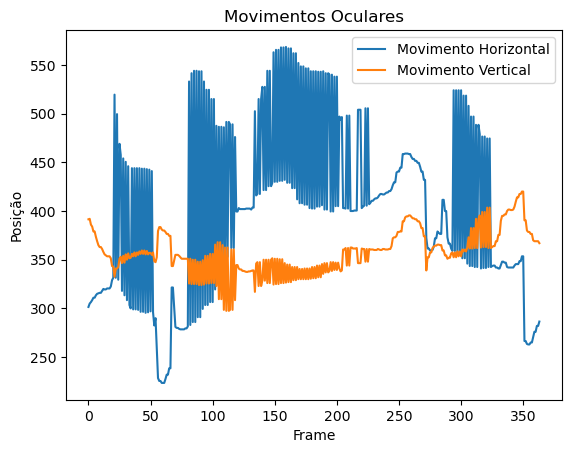

In [1]:
import cv2
import dlib
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

class NeuroBehaviorToolkit:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        self.blink_counter = 0
        self.eye_movements = []
        self.body_movements = []
        self.emotions = []
        self.memory_task_responses = []

    def start_assessment(self, duration_seconds=10):
        """Inicia a avaliação geral por vídeo."""
        cap = cv2.VideoCapture(0)
        start_time = datetime.now()

        while (datetime.now() - start_time).seconds < duration_seconds:
            ret, frame = cap.read()
            if not ret:
                break
            self.process_frame(frame)
            cv2.imshow("Avaliação Neuropsicológica", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def process_frame(self, frame):
        """Processa um frame para detectar piscadas, movimentos e expressões faciais."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray)

        for face in faces:
            landmarks = self.predictor(gray, face)

            # Detecta piscadas
            if self.is_blinking(landmarks):
                self.blink_counter += 1

            # Rastreia movimentos oculares
            eye_center = self.get_eye_center(landmarks, [36, 39])
            self.eye_movements.append(eye_center)

            # Detecta expressões faciais (emocional)
            emotion = self.detect_emotion(landmarks)
            self.emotions.append(emotion)

        # Detecta movimentos corporais
        movement_intensity = self.detect_body_movement(frame)
        self.body_movements.append(movement_intensity)

    def is_blinking(self, landmarks):
        """Verifica se o olho está piscando."""
        left_ear = self.calculate_eye_aspect_ratio(landmarks, [36, 37, 38, 39, 40, 41])
        right_ear = self.calculate_eye_aspect_ratio(landmarks, [42, 43, 44, 45, 46, 47])
        return left_ear < 0.25 or right_ear < 0.25

    def detect_emotion(self, landmarks):
        """Simples detecção de expressão emocional (exemplo)."""
        mouth_aspect_ratio = self.calculate_mouth_aspect_ratio(landmarks, [48, 51, 57, 54])
        if mouth_aspect_ratio > 0.5:
            return "Euforia"
        elif mouth_aspect_ratio < 0.3:
            return "Tristeza"
        return "Neutro"

    def calculate_eye_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto do olho (EAR)."""
        p1, p2, p3, p4, p5, p6 = [landmarks.part(i) for i in points]
        horizontal_dist = np.linalg.norm([p4.x - p1.x, p4.y - p1.y])
        vertical_dist = (np.linalg.norm([p2.x - p6.x, p2.y - p6.y]) +
                         np.linalg.norm([p3.x - p5.x, p3.y - p5.y])) / 2.0
        return vertical_dist / horizontal_dist

    def calculate_mouth_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto da boca."""
        p1, p2, p3, p4 = [landmarks.part(i) for i in points]
        vertical_dist = np.linalg.norm([p2.x - p3.x, p2.y - p3.y])
        horizontal_dist = np.linalg.norm([p1.x - p4.x, p1.y - p4.y])
        return vertical_dist / horizontal_dist

    def get_eye_center(self, landmarks, points):
        """Calcula o centro do olho."""
        x = np.mean([landmarks.part(p).x for p in points])
        y = np.mean([landmarks.part(p).y for p in points])
        return (x, y)

    def detect_body_movement(self, frame):
        """Detecta movimento corporal."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if hasattr(self, 'previous_frame'):
            diff = cv2.absdiff(self.previous_frame, gray)
            movement = np.sum(diff) / (frame.shape[0] * frame.shape[1])
        else:
            movement = 0
        self.previous_frame = gray
        return movement

    def memory_task(self):
        """Simula uma tarefa cognitiva de memória (inspirado no RAVLT)."""
        print("Lembre-se desta sequência: GATO, LIVRO, FLOR")
        response = input("Digite a sequência na ordem correta: ")
        self.memory_task_responses.append(response.strip().upper())

    def generate_report(self):
        """Gera o relatório com base nos dados coletados."""
        print("\n--- Relatório de Avaliação ---")
        print(f"Piscos Detectados: {self.blink_counter}")
        print(f"Média de Movimento Corporal: {np.mean(self.body_movements):.2f}")

        if np.mean(self.body_movements) > 0.02:
            print("- Hiperatividade: Movimentos corporais elevados detectados.")

        print(f"Expressões Emocionais: {set(self.emotions)}")
        if "Euforia" in self.emotions and "Tristeza" in self.emotions:
            print("- Bipolaridade: Flutuações emocionais extremas detectadas.")

        print("\nTarefa de Memória:")
        if "GATO LIVRO FLOR" in self.memory_task_responses:
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de memória. Possível déficit cognitivo.")

        self.plot_eye_movements()

    def plot_eye_movements(self):
        """Gera um gráfico dos movimentos oculares."""
        eye_x = [pos[0] for pos in self.eye_movements]
        eye_y = [pos[1] for pos in self.eye_movements]

        plt.plot(eye_x, label='Movimento Horizontal')
        plt.plot(eye_y, label='Movimento Vertical')
        plt.title('Movimentos Oculares')
        plt.xlabel('Frame')
        plt.ylabel('Posição')
        plt.legend()
        plt.show()

# Executar a avaliação
toolkit = NeuroBehaviorToolkit()
toolkit.memory_task()
toolkit.start_assessment(duration_seconds=30)


Lembre-se desta palavra: gato

Agora, digite um anagrama da palavra:


 otag


- Resposta Correta!
Lembre-se destes símbolos: 😂 😍 😎 😢

Agora digite os símbolos na ordem correta:


 😎 🎉 😂 😢


- Erro na tarefa de memória.
Lembre-se da seguinte matriz:
[[8 4 9]
 [5 3 6]
 [8 5 8]]

Agora digite os números da linha 2 na ordem correta:


 5 3 6


- Resposta Correta!

--- Relatório de Avaliação ---
Piscos Detectados: 61
Média de Movimento Corporal: 1.65
- Hiperatividade: Movimentos corporais elevados detectados.
Expressões Emocionais: {'neutral', 'surprise', 'angry', 'fear', 'sad', 'happy'}

Respostas às Tarefas de Memória:
- Resposta: otag
- Resposta: 😎 🎉 😂 😢
- Resposta: 5 3 6


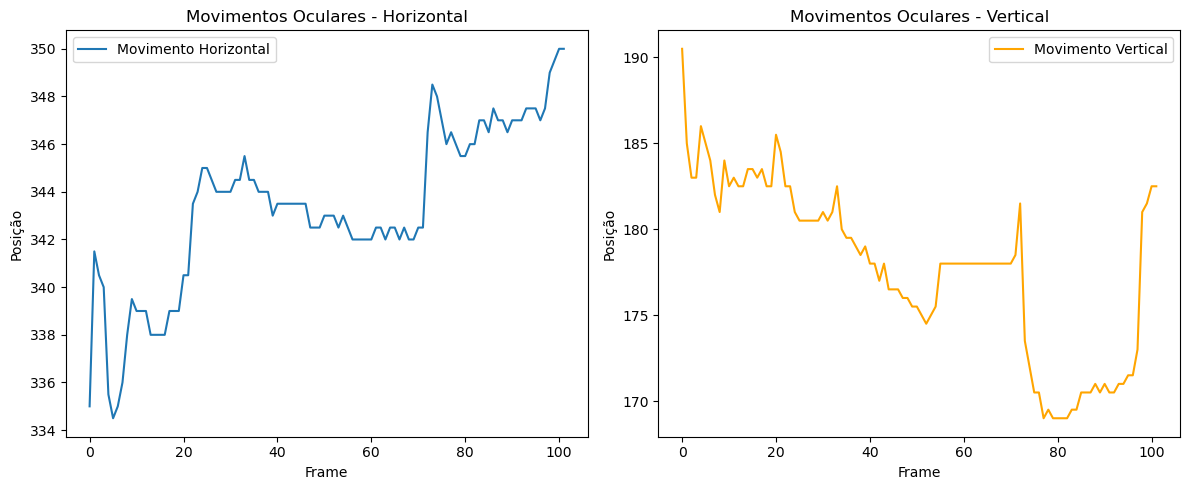

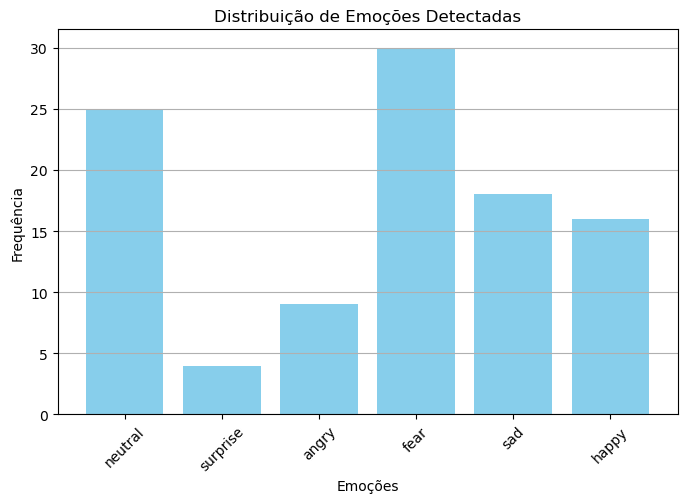

In [9]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from itertools import permutations
import mediapipe as mp
from fer import FER

class NeuroBehaviorToolkit:
    def __init__(self):
        # Inicialização do detector de faces
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # Inicialização do MediaPipe para análise facial
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=False)

        # Inicialização do FER para detecção de emoções
        self.emotion_detector = FER()
        
        # Inicialização das variáveis
        self.blink_counter = 0
        self.eye_movements = []
        self.body_movements = []
        self.emotions = []
        self.memory_task_responses = []
        self.previous_frame = None

    def start_assessment(self, duration_seconds=10):
        """Inicia a avaliação geral por vídeo."""
        cap = cv2.VideoCapture(0)
        start_time = time.time()

        while (time.time() - start_time) < duration_seconds:
            ret, frame = cap.read()
            if not ret:
                break
            
            self.process_frame(frame)
            cv2.imshow("Avaliação Neuropsicológica", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def process_frame(self, frame):
        """Processa um frame para detectar piscadas, movimentos e expressões faciais."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray)

        for face in faces:
            landmarks = self.landmark_predictor(gray, face)
            self.detect_blink(landmarks)

            # Rastreia movimentos oculares
            eye_center = self.get_eye_center(landmarks, [36, 39])
            self.eye_movements.append(eye_center)

            # Detecta emoções usando FER
            emotion, score = self.detect_emotion(frame)
            self.emotions.append(emotion)

        # Detecta movimentos corporais
        movement_intensity = self.detect_body_movement(frame)
        self.body_movements.append(movement_intensity)

    def detect_blink(self, landmarks):
        """Verifica se o olho está piscando e aumenta o contador."""
        left_ear = self.calculate_eye_aspect_ratio(landmarks, [36, 37, 38, 39, 40, 41])
        right_ear = self.calculate_eye_aspect_ratio(landmarks, [42, 43, 44, 45, 46, 47])
        if left_ear < 0.25 or right_ear < 0.25:
            self.blink_counter += 1

    def detect_emotion(self, frame):
        """Detecta emoções usando a biblioteca FER."""
        result = self.emotion_detector.detect_emotions(frame)
        if result:
            emotion = max(result[0]['emotions'], key=result[0]['emotions'].get)
            score = result[0]['emotions'][emotion]
            return emotion, score
        return "Neutro", 0

    def calculate_eye_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto do olho (EAR)."""
        p1, p2, p3, p4, p5, p6 = [landmarks.part(i) for i in points]
        horizontal_dist = np.linalg.norm([p4.x - p1.x, p4.y - p1.y])
        vertical_dist = (np.linalg.norm([p2.x - p6.x, p2.y - p6.y]) +
                         np.linalg.norm([p3.x - p5.x, p3.y - p5.y])) / 2.0
        return vertical_dist / horizontal_dist

    def get_eye_center(self, landmarks, points):
        """Calcula o centro do olho."""
        x = np.mean([landmarks.part(p).x for p in points])
        y = np.mean([landmarks.part(p).y for p in points])
        return (x, y)

    def detect_body_movement(self, frame):
        """Detecta movimento corporal."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if self.previous_frame is not None:
            diff = cv2.absdiff(self.previous_frame, gray)
            movement = np.sum(diff) / (frame.shape[0] * frame.shape[1])
        else:
            movement = 0
        self.previous_frame = gray
        return movement

    def memory_task_anagrams(self):
        """Simula uma tarefa cognitiva de anagramas."""
        word = "gato"
        print(f"Lembre-se desta palavra: {word}")
        time.sleep(5)  # Tempo para o participante memorizar

        print("\nAgora, digite um anagrama da palavra:")
        response = input().strip()
        self.memory_task_responses.append(response)

        # Gerar todos os anagramas da palavra
        anagrams = set([''.join(p) for p in permutations(word)])
        if response in anagrams:
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de anagramas.")

    def memory_task_sequence_symbols(self):
        """Simula uma tarefa cognitiva com sequência de símbolos."""
        symbols = ["😊", "😂", "😍", "😢", "😎", "👍", "🎉", "🌍"]
        selected_symbols = random.sample(symbols, 4)  # Seleciona 4 símbolos aleatórios
        print(f"Lembre-se destes símbolos: {' '.join(selected_symbols)}")

        time.sleep(5)  # Tempo para o participante memorizar
        print("\nAgora digite os símbolos na ordem correta:")
        response = input()
        self.memory_task_responses.append(response.strip())

        if response.strip() == ''.join(selected_symbols):
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de memória.")

    def memory_task_matrix(self):
        """Simula um teste de matriz."""
        matrix = np.random.randint(1, 10, (3, 3))  # Matriz 3x3 com números de 1 a 9
        print("Lembre-se da seguinte matriz:")
        print(matrix)

        time.sleep(5)  # Tempo para o participante memorizar
        row_col = random.choice(['row', 'column'])
        if row_col == 'row':
            selected_index = random.randint(0, 2)
            print(f"\nAgora digite os números da linha {selected_index + 1} na ordem correta:")
            correct_response = ' '.join(map(str, matrix[selected_index]))
        else:
            selected_index = random.randint(0, 2)
            print(f"\nAgora digite os números da coluna {selected_index + 1} na ordem correta:")
            correct_response = ' '.join(map(str, matrix[:, selected_index]))

        response = input()
        self.memory_task_responses.append(response.strip())

        if response.strip() == correct_response:
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de matriz.")

    def generate_report(self):
        """Gera o relatório com base nos dados coletados."""
        print("\n--- Relatório de Avaliação ---")
        print(f"Piscos Detectados: {self.blink_counter}")
        print(f"Média de Movimento Corporal: {np.mean(self.body_movements):.2f}")

        if np.mean(self.body_movements) > 0.02:
            print("- Hiperatividade: Movimentos corporais elevados detectados.")

        print(f"Expressões Emocionais: {set(self.emotions)}")
        if "Euforia" in self.emotions and "Tristeza" in self.emotions:
            print("- Bipolaridade: Flutuações emocionais extremas detectadas.")

        print("\nRespostas às Tarefas de Memória:")
        for response in self.memory_task_responses:
            print(f"- Resposta: {response}")

        self.plot_eye_movements()
        self.plot_emotion_distribution()

    def plot_eye_movements(self):
        """Gera um gráfico dos movimentos oculares."""
        eye_x = [pos[0] for pos in self.eye_movements]
        eye_y = [pos[1] for pos in self.eye_movements]

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(eye_x, label='Movimento Horizontal')
        plt.title('Movimentos Oculares - Horizontal')
        plt.xlabel('Frame')
        plt.ylabel('Posição')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(eye_y, label='Movimento Vertical', color='orange')
        plt.title('Movimentos Oculares - Vertical')
        plt.xlabel('Frame')
        plt.ylabel('Posição')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_emotion_distribution(self):
        """Gera um gráfico de distribuição das emoções detectadas."""
        emotion_counts = {emotion: self.emotions.count(emotion) for emotion in set(self.emotions)}
        
        plt.figure(figsize=(8, 5))
        plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
        plt.title('Distribuição de Emoções Detectadas')
        plt.xlabel('Emoções')
        plt.ylabel('Frequência')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()

# Executar a avaliação
toolkit = NeuroBehaviorToolkit()
toolkit.memory_task_anagrams()
toolkit.memory_task_sequence_symbols()
toolkit.memory_task_matrix()
toolkit.start_assessment(duration_seconds=30)



--- Relatório de Avaliação ---
Piscos Detectados: 111
Média de Movimento Corporal: 4.58
- Hiperatividade: Alta
Emoções Detectadas: ['sad', 'sad', 'sad', 'fear', 'sad', 'sad', 'angry', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'fear', 'surprise', 'fear', 'surprise', 'angry', 'angry', 'angry', 'surprise', 'fear', 'sad', 'sad', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'fear', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'sad', 'fear', 'sad', 'fear', 'fear', 'fear', 'fear', 'fear', 'sad', 'sad', 'sad', 'fear'

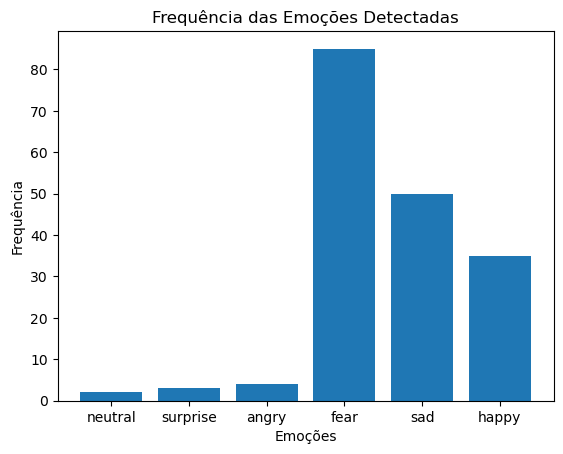

Lembre-se desta palavra: gato

Agora, digite um anagrama da palavra: (Um anagrama é uma reorganização das letras de uma palavra para formar outra palavra.)


 otag


- Resposta Correta!
Lembre-se destes símbolos: 😎 🎉 😂 😢

Agora digite os símbolos na ordem correta:


 😎 🎉 😂 😢


- Erro na tarefa de memória.
Lembre-se da seguinte matriz:
[[3 2 6]
 [8 6 5]
 [8 3 6]]

Agora digite os números da linha 3 na ordem correta:


 8 3 6


- Resposta Correta!


In [8]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from itertools import permutations
import mediapipe as mp
from fer import FER

class NeuroBehaviorToolkit:
    def __init__(self):
        # Inicialização do detector de faces
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # Inicialização do MediaPipe para análise facial
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=False)

        # Inicialização do FER para detecção de emoções
        self.emotion_detector = FER()
        
        # Inicialização das variáveis
        self.blink_counter = 0
        self.eye_movements = []
        self.body_movements = []
        self.emotions = []
        self.memory_task_responses = []
        self.previous_frame = None
        self.current_emotion = "Neutro"  # Emoção atual exibida
        self.emotion_score = 0  # Pontuação da emoção

    def start_assessment(self, duration_seconds=30):
        """Inicia a avaliação geral por vídeo."""
        cap = cv2.VideoCapture(0)
        start_time = time.time()

        while (time.time() - start_time) < duration_seconds:
            ret, frame = cap.read()
            if not ret:
                break
            
            self.process_frame(frame)

            # Exibe a emoção atual na tela
            self.display_emotion(frame)
            
            cv2.imshow("Avaliação Neuropsicológica", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def process_frame(self, frame):
        """Processa um frame para detectar piscadas, movimentos e expressões faciais."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray)

        for face in faces:
            landmarks = self.landmark_predictor(gray, face)
            self.detect_blink(landmarks)

            # Rastreia movimentos oculares
            eye_center = self.get_eye_center(landmarks, [36, 39])
            self.eye_movements.append(eye_center)

            # Detecta emoções usando FER
            emotion, score = self.detect_emotion(frame)
            self.current_emotion = emotion
            self.emotion_score = score
            self.emotions.append(emotion)

        # Detecta movimentos corporais
        movement_intensity = self.detect_body_movement(frame)
        self.body_movements.append(movement_intensity)

    def display_emotion(self, frame):
        """Exibe a emoção atual na tela."""
        emotion_text = f"Emoção: {self.current_emotion} (Pontuação: {self.emotion_score:.2f})"
        cv2.putText(frame, emotion_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    def detect_blink(self, landmarks):
        """Verifica se o olho está piscando e aumenta o contador."""
        left_ear = self.calculate_eye_aspect_ratio(landmarks, [36, 37, 38, 39, 40, 41])
        right_ear = self.calculate_eye_aspect_ratio(landmarks, [42, 43, 44, 45, 46, 47])
        if left_ear < 0.25 or right_ear < 0.25:
            self.blink_counter += 1

    def detect_emotion(self, frame):
        """Detecta emoções usando a biblioteca FER."""
        result = self.emotion_detector.detect_emotions(frame)
        if result:
            emotion = max(result[0]['emotions'], key=result[0]['emotions'].get)
            score = result[0]['emotions'][emotion]
            return emotion, score
        return "Neutro", 0

    def calculate_eye_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto do olho (EAR)."""
        p1, p2, p3, p4, p5, p6 = [landmarks.part(i) for i in points]
        horizontal_dist = np.linalg.norm([p4.x - p1.x, p4.y - p1.y])
        vertical_dist = (np.linalg.norm([p2.x - p6.x, p2.y - p6.y]) +
                         np.linalg.norm([p3.x - p5.x, p3.y - p5.y])) / 2.0
        return vertical_dist / horizontal_dist

    def get_eye_center(self, landmarks, points):
        """Calcula o centro do olho."""
        x = np.mean([landmarks.part(p).x for p in points])
        y = np.mean([landmarks.part(p).y for p in points])
        return (x, y)

    def detect_body_movement(self, frame):
        """Detecta movimento corporal."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if self.previous_frame is not None:
            diff = cv2.absdiff(self.previous_frame, gray)
            movement = np.sum(diff) / (frame.shape[0] * frame.shape[1])
        else:
            movement = 0
        self.previous_frame = gray
        return movement

    def memory_task_anagrams(self):
        """Simula uma tarefa cognitiva de anagramas."""
        word = "gato"
        print(f"Lembre-se desta palavra: {word}")
        time.sleep(5)  # Tempo para o participante memorizar

        print("\nAgora, digite um anagrama da palavra: (Um anagrama é uma reorganização das letras de uma palavra para formar outra palavra.)")
        response = input().strip()
        self.memory_task_responses.append(response)

        # Gerar todos os anagramas da palavra
        anagrams = set([''.join(p) for p in permutations(word)])
        if response in anagrams:
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de anagramas.")

    def memory_task_sequence_symbols(self):
        """Simula uma tarefa cognitiva com sequência de símbolos."""
        symbols = ["😊", "😂", "😍", "😢", "😎", "👍", "🎉", "🌍"]
        selected_symbols = random.sample(symbols, 4)  # Seleciona 4 símbolos aleatórios
        print(f"Lembre-se destes símbolos: {' '.join(selected_symbols)}")

        time.sleep(5)  # Tempo para o participante memorizar
        print("\nAgora digite os símbolos na ordem correta:")
        response = input()
        self.memory_task_responses.append(response.strip())

        if response.strip() == ''.join(selected_symbols):
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de memória.")

    def memory_task_matrix(self):
        """Simula um teste de matriz."""
        matrix = np.random.randint(1, 10, (3, 3))  # Matriz 3x3 com números de 1 a 9
        print("Lembre-se da seguinte matriz:")
        print(matrix)

        time.sleep(5)  # Tempo para o participante memorizar
        row_col = random.choice(['row', 'column'])
        if row_col == 'row':
            selected_index = random.randint(0, 2)
            print(f"\nAgora digite os números da linha {selected_index + 1} na ordem correta:")
            correct_response = ' '.join(map(str, matrix[selected_index]))
        else:
            selected_index = random.randint(0, 2)
            print(f"\nAgora digite os números da coluna {selected_index + 1} na ordem correta:")
            correct_response = ' '.join(map(str, matrix[:, selected_index]))

        response = input()
        self.memory_task_responses.append(response.strip())

        if response.strip() == correct_response:
            print("- Resposta Correta!")
        else:
            print("- Erro na tarefa de matriz.")

    def generate_report(self):
        """Gera o relatório com base nos dados coletados."""
        print("\n--- Relatório de Avaliação ---")
        print(f"Piscos Detectados: {self.blink_counter}")
        print(f"Média de Movimento Corporal: {np.mean(self.body_movements):.2f}")

        if np.mean(self.body_movements) > 0.02:
            print("- Hiperatividade: Alta")
        else:
            print("- Hiperatividade: Normal")

        print(f"Emoções Detectadas: {self.emotions}")
        print(f"Respostas de Tarefa de Memória: {self.memory_task_responses}")

        # Análise das emoções
        emotion_counts = {emotion: self.emotions.count(emotion) for emotion in set(self.emotions)}
        plt.bar(emotion_counts.keys(), emotion_counts.values())
        plt.title("Frequência das Emoções Detectadas")
        plt.xlabel("Emoções")
        plt.ylabel("Frequência")
        plt.show()


# Para executar a avaliação
if __name__ == "__main__":
    toolkit = NeuroBehaviorToolkit()
    toolkit.start_assessment(duration_seconds=30)
    toolkit.memory_task_anagrams()
    toolkit.memory_task_sequence_symbols()
    toolkit.memory_task_matrix()


In [2]:
import cv2
import dlib
import numpy as np
import random
import time
import mediapipe as mp
from fer import FER
import speech_recognition as sr
from itertools import permutations
import unidecode  # Para remover acentos

class NeuroBehaviorToolkit:
    def __init__(self):
        # Inicialização do detector de faces
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # Inicialização do MediaPipe para análise facial
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=False)

        # Inicialização do FER para detecção de emoções
        self.emotion_detector = FER()
        
        # Inicialização das variáveis
        self.blink_counter = 0
        self.eye_movements = []
        self.body_movements = []
        self.emotions = []
        self.memory_task_responses = []
        self.previous_frame = None
        self.current_emotion = "neutro"  # Emoção atual exibida
        self.emotion_score = 0  # Pontuação da emoção

    def start_assessment(self, duration_seconds=30):
        """Inicia a avaliação geral por vídeo."""
        cap = cv2.VideoCapture(0)
        start_time = time.time()

        while (time.time() - start_time) < duration_seconds:
            ret, frame = cap.read()
            if not ret:
                break
            
            self.process_frame(frame)

            # Exibe a emoção atual na tela
            self.display_emotion(frame)

            # Execute a tarefa de memória
            self.memory_task_anagrams(frame)

            cv2.imshow("Avaliacao Neuropsicologica", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def process_frame(self, frame):
        """Processa um frame para detectar piscadas, movimentos e expressões faciais."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray)

        for face in faces:
            landmarks = self.landmark_predictor(gray, face)
            self.detect_blink(landmarks)

            # Rastreia movimentos oculares
            eye_center = self.get_eye_center(landmarks, [36, 39])
            self.eye_movements.append(eye_center)

            # Detecta emoções usando FER
            emotion, score = self.detect_emotion(frame)
            self.current_emotion = emotion
            self.emotion_score = score
            self.emotions.append(emotion)

        # Detecta movimentos corporais
        movement_intensity = self.detect_body_movement(frame)
        self.body_movements.append(movement_intensity)

    def display_emotion(self, frame):
        """Exibe a emoção atual na tela."""
        emotion_text = f"Emocao: {self.current_emotion} (Pontuação: {self.emotion_score:.2f})"
        cv2.putText(frame, emotion_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    def detect_blink(self, landmarks):
        """Verifica se o olho está piscando e aumenta o contador."""
        left_ear = self.calculate_eye_aspect_ratio(landmarks, [36, 37, 38, 39, 40, 41])
        right_ear = self.calculate_eye_aspect_ratio(landmarks, [42, 43, 44, 45, 46, 47])
        if left_ear < 0.25 or right_ear < 0.25:
            self.blink_counter += 1

    def detect_emotion(self, frame):
        """Detecta emoções usando a biblioteca FER."""
        result = self.emotion_detector.detect_emotions(frame)
        if result:
            emotion = max(result[0]['emotions'], key=result[0]['emotions'].get)
            score = result[0]['emotions'][emotion]
            return emotion, score
        return "Neutro", 0

    def calculate_eye_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto do olho (EAR)."""
        p1, p2, p3, p4, p5, p6 = [landmarks.part(i) for i in points]
        horizontal_dist = np.linalg.norm([p4.x - p1.x, p4.y - p1.y])
        vertical_dist = (np.linalg.norm([p2.x - p6.x, p2.y - p6.y]) +
                         np.linalg.norm([p3.x - p5.x, p3.y - p5.y])) / 2.0
        return vertical_dist / horizontal_dist

    def get_eye_center(self, landmarks, points):
        """Calcula o centro do olho."""
        x = np.mean([landmarks.part(p).x for p in points])
        y = np.mean([landmarks.part(p).y for p in points])
        return (x, y)

    def detect_body_movement(self, frame):
        """Detecta movimento corporal."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if self.previous_frame is not None:
            diff = cv2.absdiff(self.previous_frame, gray)
            movement = np.sum(diff) / (frame.shape[0] * frame.shape[1])
        else:
            movement = 0
        self.previous_frame = gray
        return movement

    def memory_task_anagrams(self, frame):
        """Simula uma tarefa cognitiva de anagramas."""
        words = ["gato", "pato", "casa", "bola", "carro", "flor"]  # Lista de palavras
        selected_words = random.sample(words, 3)  # Seleciona 3 palavras aleatórias
        display_text = f"Lembre-se: {', '.join(selected_words)}"
        
        # Exibir as palavras na tela
        cv2.putText(frame, display_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow("Avaliação Neuropsicológica", frame)  # Mostrar a palavra
        cv2.waitKey(5000)  # Tempo para o participante memorizar

        # Agora, ativa o microfone para reconhecer a fala
        response = self.recognize_speech()
        response = unidecode.unidecode(response)  # Remove acentos
        self.memory_task_responses.append(response)

        # Gerar todos os anagramas das palavras selecionadas
        anagrams = set([''.join(p) for word in selected_words for p in permutations(word)])
        if response in anagrams:
            feedback_text = "- Resposta Correta!"
        else:
            feedback_text = "- Erro na tarefa de anagramas."

        # Exibir feedback na tela
        cv2.putText(frame, feedback_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("Avaliacao", frame)  # Mostrar feedback
        cv2.waitKey(2000)  # Mostrar feedback por 2 segundos

    def recognize_speech(self):
        """Reconhece fala do usuário usando a biblioteca SpeechRecognition."""
        r = sr.Recognizer()
        with sr.Microphone() as source:
            time.sleep(5)  # Atraso para ajuste do microfone
            print("Diga a resposta:")
            r.adjust_for_ambient_noise(source)
            audio = r.listen(source)

            try:
                response = r.recognize_google(audio, language="pt-BR")  # Usando Google para reconhecimento de voz
                return response
            except sr.UnknownValueError:
                return "Não entendi"
            except sr.RequestError:
                return "Erro no serviço de reconhecimento"

    def generate_report(self):
        """Gera o relatório com base nos dados coletados."""
        print("\n--- Relatório de Avaliação ---")
        print(f"Piscos Detectados: {self.blink_counter}")
        print(f"Média de Movimento Corporal: {np.mean(self.body_movements):.2f}")

        if np.mean(self.body_movements) > 0.02:
            print("- Hiperatividade: Alta")
        else:
            print("- Hiperatividade: Normal")

        print(f"Emoções Detectadas: {self.emotions}")
        print(f"Respostas de Tarefa de Memória: {self.memory_task_responses}")


# Para executar a avaliação
if __name__ == "__main__":
    toolkit = NeuroBehaviorToolkit()
    toolkit.start_assessment(duration_seconds=30)


Diga a resposta:

--- Relatório de Avaliação ---
Piscos Detectados: 0
Média de Movimento Corporal: 0.00
- Hiperatividade: Normal
Emoções Detectadas: []
Respostas de Tarefa de Memória: ['Nao entendi']
